<a href="https://colab.research.google.com/github/deniseiras/BAM1D-Microphysics-Emulation/blob/main/BAM1D_Physics_Emulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BAM1D Physics Emulation

<font size="5">**Objetivo:** Emular a Hugh Morrison Microphysics implementada em BAM1D</font>
 


SUBROUTINE RunMicro_HugMorr(  
  
**ncols** - numero de colunas - fixo = 1  
nCols       , &!INTEGER      , INTENT(IN   ) :: nCols

**kmax** - número de níveis = 28  
kMax        , &!INTEGER      , INTENT(IN   ) :: kMax 

**si** - kmax+1 removido, sem valores/usado
si          , &!REAL(KIND=r8), INTENT(IN   ) :: si(kMax+1)

**sl**  
sl          , &!REAL(KIND=r8), INTENT(IN   ) :: sl(kMax)

**tc** - Temperature(K)  
tc          , &!REAL(KIND=r8), INTENT(INOUT) :: Tc (1:nCols, 1:kMax)

<font size="5">Q's - Mixing ratio </font>

**QV** - water vapor  
QV          , &!REAL(KIND=r8), INTENT(INOUT) :: qv (1:nCols, 1:kMax)

**QC** - cloud water  
QC          , &!REAL(KIND=r8), INTENT(INOUT) :: qc (1:nCols, 1:kMax)

**QR**  - rain water  
QR          , &!REAL(KIND=r8), INTENT(INOUT) :: qr (1:nCols, 1:kMax)

**QI** - cloud ice  
QI          , &!REAL(KIND=r8), INTENT(INOUT) :: qi (1:nCols, 1:kMax)

**QS** - Snow  
QS          , &!REAL(KIND=r8), INTENT(INOUT) :: qs (1:nCols, 1:kMax)

**QG** - Graupel  
QG          , &!REAL(KIND=r8), INTENT(INOUT) :: qg (1:nCols, 1:kMax)

<font size="5">*N's* - number concentration
</font>  

**NI** - cloud ice  
NI          , &!REAL(KIND=r8), INTENT(INOUT) :: ni (1:nCols, 1:kMax)

**NS** - Snow  
NS          , &!REAL(KIND=r8), INTENT(INOUT) :: ns (1:nCols, 1:kMax)

**NR** - Rain    
NR          , &!REAL(KIND=r8), INTENT(INOUT) :: nr (1:nCols, 1:kMax)

**NG** - Graupel  
NG          , &!REAL(KIND=r8), INTENT(INOUT) :: NG (1:nCols, 1:kMax)   

**NC** - Cloud droplet  
NC          , &!REAL(KIND=r8), INTENT(INOUT) :: NC (1:nCols, 1:kMax)   

**TKE** - turbulence kinetic energy (m^2 s-2), NEEDED FOR DROPLET ACTIVATION  
TKE         , &!REAL(KIND=r8), INTENT(IN   ) :: TKE (1:nCols, 1:kMax)   

**KZH** -  heat eddy diffusion coefficient from YSU scheme (M^2 S-1), NEEDED FOR DROPLET ACTIVATION  
KZH         , &!REAL(KIND=r8), INTENT(IN   ) :: KZH (1:nCols, 1:kMax)   

**gps** - Pressão - removida da entrada da RNA - valor fixo  
gps         , &!gps- AIR PRESSURE (PA)

**DT_IN** - model time step (sec) - Removido da entrada da RNA
DT_IN       , &!REAL(KIND=r8), INTENT(IN   ) :: dt_in

**omega**  
omega       , &!REAL(KIND=r8), INTENT(IN   ) :: omega  ! omega (Pa/s)

**EFFCS** - CLOUD DROPLET EFFECTIVE RADIUS OUTPUT TO RADIATION CODE (micron)  
EFFCS       , &!REAL(KIND=r8), INTENT(OUT  ) :: EFFCS (1:nCols, 1:kMax)   

**EFFIS** - CLOUD DROPLET EFFECTIVE RADIUS OUTPUT TO RADIATION CODE (micron)  
EFFIS       , &!REAL(KIND=r8), INTENT(OUT  ) :: EFFIS (1:nCols, 1:kMax)   

**LSRAIN** - Large scale Rain  
LSRAIN      , &!REAL(KIND=r8), INTENT(OUT) :: LSRAIN(1:nCols)

**LSSNOW** - Large scale Snow  
LSSNOW        )!REAL(KIND=r8), INTENT(OUT) :: LSSNOW(1:nCols)


# Setup do dados

Carregamento dos dados

In [5]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from sklearn import metrics

# %tensorflow_version 1.x

import tensorflow as tf
import keras
from tensorflow.python.data import Dataset

from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard
import csv    

from datetime import datetime
from shutil import copyfile, copytree, rmtree

# % pip install XlsxWriter
# % pip install SkillMetrics
# import skill_metrics as sm


# tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
# pd.options.display.float_format = '{:.1f}'.format
pd.options.display.float_format = '{:f}'.format


# working local
#
# %load_ext tensorboard funciona local ???
# %reload_ext tensorboard ???
# original_input_df = pd.read_csv("/home/denis/_COM_BACKUP/bam1d_physics_nn/hug_morr_inputs.csv", sep=",")
# original_output_df = pd.read_csv("/home/denis/_COM_BACKUP/bam1d_physics_nn/hug_morr_outputs.csv", sep=",")
# tb_logdir_base = '/home/denis/_COM_BACKUP/bam1d_physics_nn/logs/'


# loading from gdrive - COLAB MOUNTS AUTOMATICALLY NOW
# from google.colab import drive
# drive.mount('/content/drive') # , force_remount=True

colab_in_drive_root_dir = "/content/drive/My Drive/Colab Notebooks/"
data_in_drive_dir = "/content/drive/My Drive/NN_Microphysics/"

# original_input_df = pd.read_csv("{}/hug_morr_inputs_CRD_RRTMG.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}/hug_morr_outputs_CRD_RRTMG.csv".format(data_in_drive_dir), sep=",")

# original_input_df = pd.read_csv("{}/hug_morr_inputs_CRD_HSR.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}/hug_morr_outputs_CRD_HSR.csv".format(data_in_drive_dir), sep=",")

original_input_df = pd.read_csv("{}/hug_morr_inputs_CRD_RRTMG___dt_60.csv".format(data_in_drive_dir), sep=",")
original_output_df = pd.read_csv("{}/hug_morr_outputs_CRD_RRTMG___dt_60.csv".format(data_in_drive_dir), sep=",")

tb_logdir_base = './logs'


## Análise dos dados

### Análise estatística

- Resumo dos valores das variáveis de entrada e saída. Observe que os valores são truncados no Resumo
- Valores do primeiro, centésimo e último passo de tempo
- Níveis verticais do primeiro, centésimo e último passo de tempo

In [6]:
print("\nAll input summary:")
display.display(original_input_df.describe())
print("\nAll output summary:")
display.display(original_output_df.describe())

print("\nInput First timestep:")
display.display(original_input_df.head(28))
print("\nInput 100th timestep:")
display.display(original_input_df.loc[2800:2800+27])
print("\nInput Last timestep:")
display.display(original_input_df.tail(28))

print("\nOutput First timestep:")
display.display(original_output_df.head(28))
print("\nOutput 100th timestep:")
display.display(original_output_df.loc[2800:2800+27])
print("\nOutput Last timestep:")
display.display(original_output_df.tail(28))

original_output_df.describe().to_csv('/content/drive/My Drive/Colab Notebooks/temp_describe.csv')




All input summary:


k             si  ...            gps          omega
count 1592668.000000 1592668.000000  ... 1592668.000000 1592668.000000
mean       14.500000       0.468551  ...   99000.000000      -0.031888
std         8.077750       0.363561  ...       0.000000       0.124602
min         1.000000       0.003669  ...   99000.000000      -1.040423
25%         7.750000       0.103880  ...   99000.000000      -0.032544
50%        14.500000       0.432240  ...   99000.000000       0.000000
75%        21.250000       0.834470  ...   99000.000000       0.013509
max        28.000000       1.000000  ...   99000.000000       0.240343

[8 rows x 20 columns]


All output summary:


k             Tc  ...         LSRAIN         LSSNOW
count 1592668.000000 1592668.000000  ... 1592668.000000 1592668.000000
mean       14.500000     243.723622  ...       0.000000       0.000000
std         8.077750      51.440699  ...       0.000001       0.000000
min         1.000000     100.655770  ...       0.000000       0.000000
25%         7.750000     197.878734  ...       0.000000       0.000000
50%        14.500000     259.338948  ...       0.000000       0.000000
75%        21.250000     289.499080  ...       0.000000       0.000000
max        28.000000     309.782468  ...       0.000012       0.000000

[8 rows x 17 columns]


Input First timestep:


k       si  si_kmax_+_1       sl  ...      tke      kzh          gps     omega
0    1 1.000000     0.000000 0.994964  ... 0.000000 1.413001 99000.000000 -0.000992
1    2 0.989934     0.000000 0.981964  ... 0.000000 5.552005 99000.000000 -0.000187
2    3 0.974009     0.000000 0.964137  ... 0.000000 0.100000 99000.000000  0.001870
3    4 0.954290     0.000000 0.942167  ... 0.000000 0.100000 99000.000000  0.002775
4    5 0.930081     0.000000 0.915361  ... 0.000000 0.100000 99000.000000 -0.001486
..  ..      ...          ...      ...  ...      ...      ...          ...       ...
23  24 0.042912     0.000000 0.035429  ... 0.000000 0.100000 99000.000000  0.000000
24  25 0.028306     0.000000 0.022285  ... 0.000000 0.100000 99000.000000  0.000000
25  26 0.016629     0.000000 0.011763  ... 0.000000 0.100000 99000.000000  0.000000
26  27 0.007338     0.000000 0.005429  ... 0.000000 0.100000 99000.000000  0.000000
27  28 0.003669     0.000000 0.001523  ... 0.000000 0.100000 99000.000000  0.000000

[28 rows x 20 columns]


Input 100th timestep:


k       si  si_kmax_+_1  ...       kzh          gps     omega
2800   1 1.000000     0.000000  ...  6.503261 99000.000000 -0.000992
2801   2 0.989934     0.000000  ... 16.399053 99000.000000 -0.000243
2802   3 0.974009     0.000000  ...  9.613993 99000.000000  0.001765
2803   4 0.954290     0.000000  ...  4.806996 99000.000000  0.002765
2804   5 0.930081     0.000000  ...  0.100000 99000.000000 -0.001204
...   ..      ...          ...  ...       ...          ...       ...
2823  24 0.042912     0.000000  ...  0.100000 99000.000000  0.000000
2824  25 0.028306     0.000000  ...  0.100000 99000.000000  0.000000
2825  26 0.016629     0.000000  ...  0.100000 99000.000000  0.000000
2826  27 0.007338     0.000000  ...  0.100000 99000.000000  0.000000
2827  28 0.003669     0.000000  ...  0.100000 99000.000000  0.000000

[28 rows x 20 columns]


Input Last timestep:


k       si  si_kmax_+_1  ...        kzh          gps     omega
1592640   1 1.000000     0.000000  ...  26.685953 99000.000000 -0.000728
1592641   2 0.989934     0.000000  ...  47.757225 99000.000000  0.001025
1592642   3 0.974009     0.000000  ...  58.986588 99000.000000  0.002903
1592643   4 0.954290     0.000000  ...  64.482763 99000.000000  0.001065
1592644   5 0.930081     0.000000  ...  79.042832 99000.000000 -0.009210
...      ..      ...          ...  ...        ...          ...       ...
1592663  24 0.042912     0.000000  ...   4.215801 99000.000000  0.000000
1592664  25 0.028306     0.000000  ...   2.107901 99000.000000  0.000000
1592665  26 0.016629     0.000000  ...   0.100000 99000.000000  0.000000
1592666  27 0.007338     0.000000  ... 300.000000 99000.000000  0.000000
1592667  28 0.003669     0.000000  ... 300.000000 99000.000000  0.000000

[28 rows x 20 columns]


Output First timestep:


k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
0    1 294.631831 0.016579 0.000200  ... 20.797154 25.000000 0.000000 0.000000
1    2 294.145509 0.016314 0.000050  ... 13.061383 25.000000 0.000000 0.000000
2    3 293.735778 0.015746 0.000000  ... 25.000000 25.000000 0.000000 0.000000
3    4 293.182341 0.015051 0.000000  ... 25.000000 25.000000 0.000000 0.000000
4    5 292.084330 0.014417 0.000000  ... 25.000000 25.000000 0.000000 0.000000
..  ..        ...      ...      ...  ...       ...       ...      ...      ...
23  24 206.522209 0.000003 0.000000  ... 25.000000 25.000000 0.000000 0.000000
24  25 211.659712 0.000024 0.000000  ... 25.000000 25.000000 0.000000 0.000000
25  26 214.657413 0.000047 0.000000  ... 25.000000 25.000000 0.000000 0.000000
26  27 215.771016 0.000056 0.000000  ... 25.000000 25.000000 0.000000 0.000000
27  28 215.772176 0.000056 0.000000  ... 25.000000 25.000000 0.000000 0.000000

[28 rows x 17 columns]


Output 100th timestep:


k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
2800   1 298.690073 0.016781 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2801   2 297.319088 0.016364 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2802   3 294.890725 0.015747 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2803   4 293.213223 0.015051 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2804   5 292.220361 0.014417 0.000000  ... 25.000000 25.000000 0.000000 0.000000
...   ..        ...      ...      ...  ...       ...       ...      ...      ...
2823  24 206.551493 0.000003 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2824  25 211.575125 0.000024 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2825  26 212.760032 0.000047 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2826  27 213.801703 0.000056 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2827  28 214.066696 0.000056 0.000000  ... 25.000000 25.000000 0.000000 0.000000

[28 rows x 17 columns]


Output Last timestep:


k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
1592640   1 302.457585 0.016781 0.000000  ... 25.000000 25.000000 0.000000 0.000000
1592641   2 301.363841 0.016364 0.000000  ... 25.000000 25.000000 0.000000 0.000000
1592642   3 299.897256 0.015747 0.000000  ... 25.000000 25.000000 0.000000 0.000000
1592643   4 298.051400 0.015052 0.000000  ... 25.000000 25.000000 0.000000 0.000000
1592644   5 295.716493 0.014418 0.000000  ... 25.000000 25.000000 0.000000 0.000000
...      ..        ...      ...      ...  ...       ...       ...      ...      ...
1592663  24 168.468645 0.000009 0.000000  ... 25.000000 25.000000 0.000000 0.000000
1592664  25 195.977968 0.000024 0.000000  ... 25.000000 13.398088 0.000000 0.000000
1592665  26 188.922854 0.000030 0.000000  ... 25.000000 25.000000 0.000000 0.000000
1592666  27 151.602548 0.000056 0.000000  ... 25.000000 25.000000 0.000000 0.000000
1592667  28 101.580781 0.000056 0.000000  ... 25.000000 25.000000 0.000000 0.000000

[28 rows x 17 columns]

### Histogramas das variáveis de entrada

In [7]:
# Input Histograms

# _ = original_input_df.hist(bins=50, figsize=(30, 20), xlabelsize=10)

### Histogramas das variáveis de saída

In [8]:
# Output Histograms

# _ = original_output_df.hist(bins=50, figsize=(30, 20), xlabelsize=10)
#_ = validation_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

### Bloxpot das variáveis de entrada por níveis

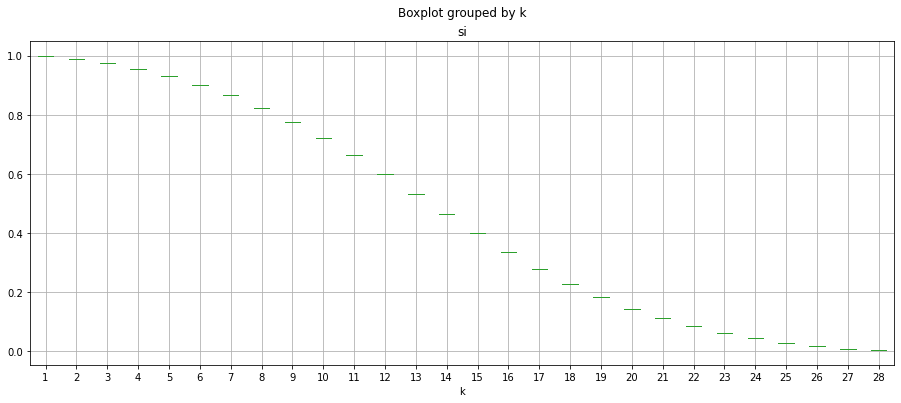

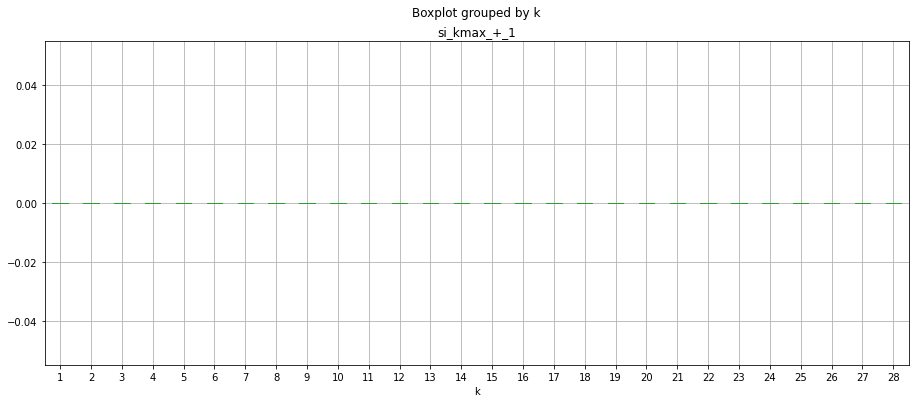

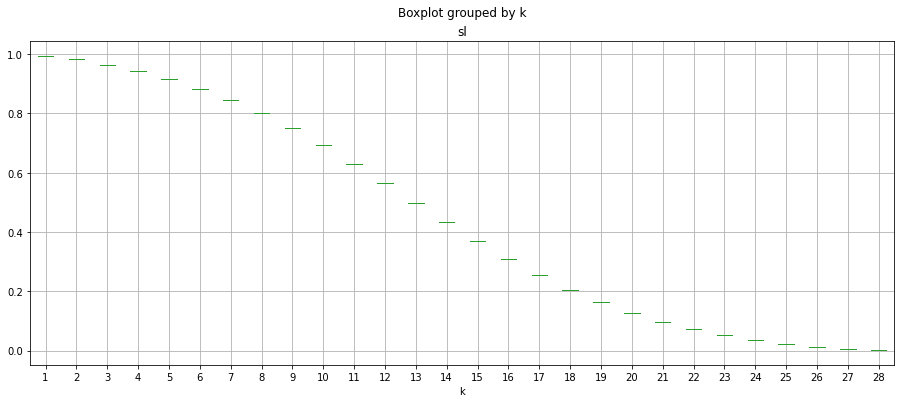

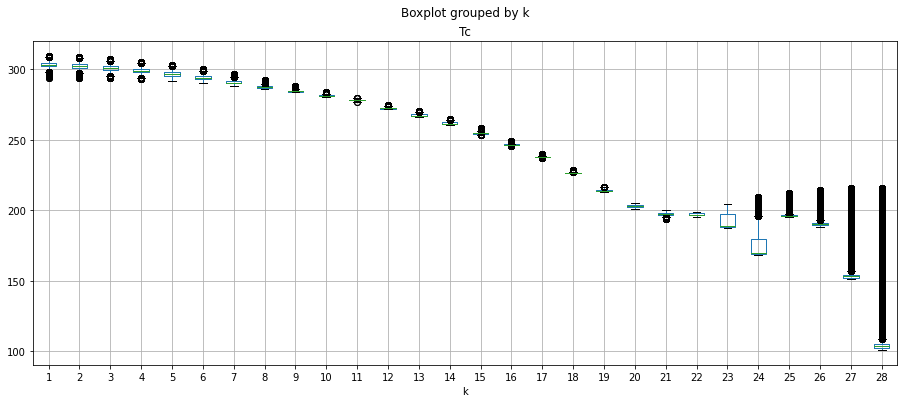

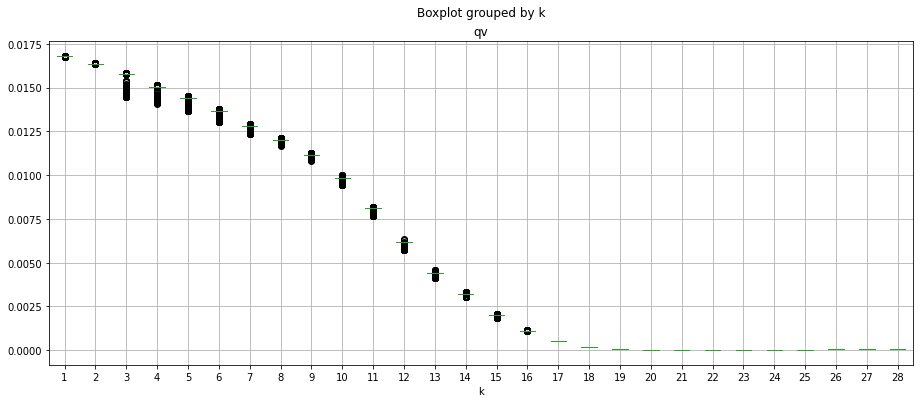

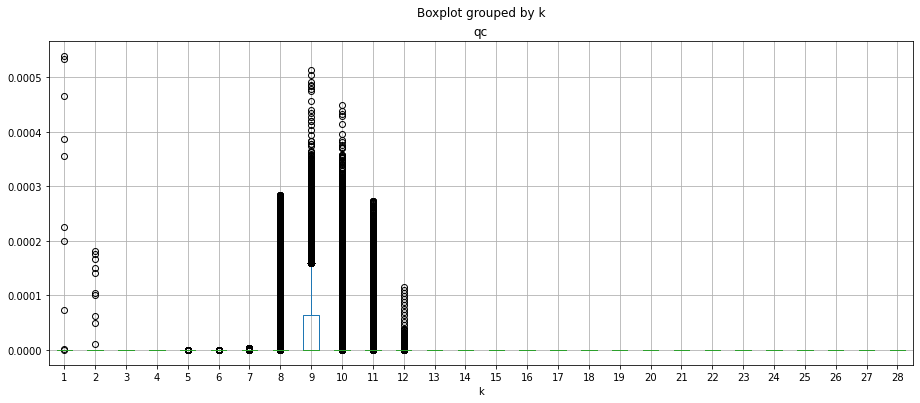

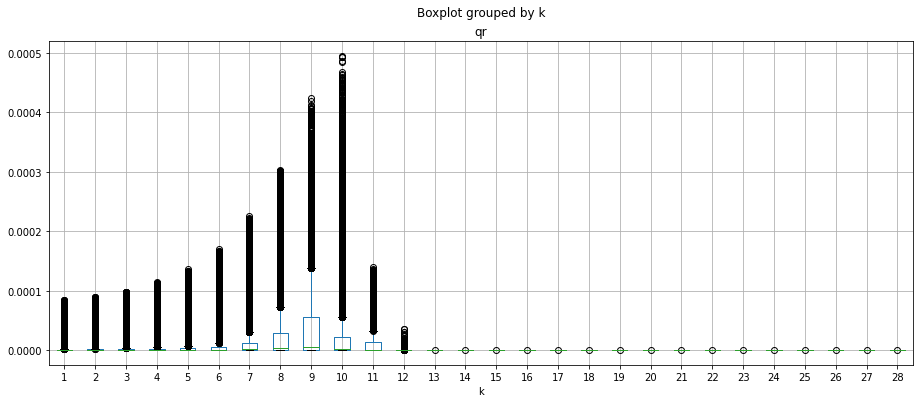

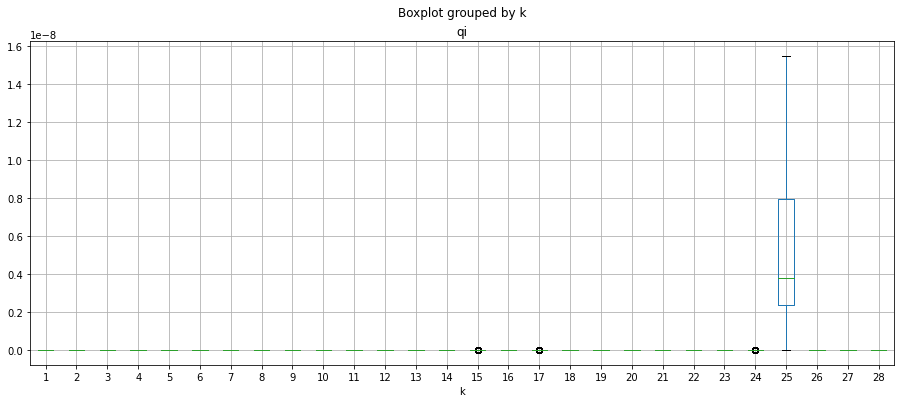

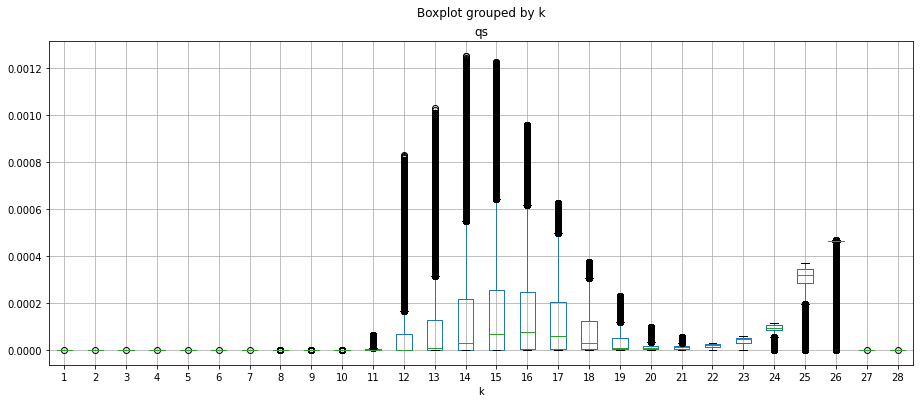

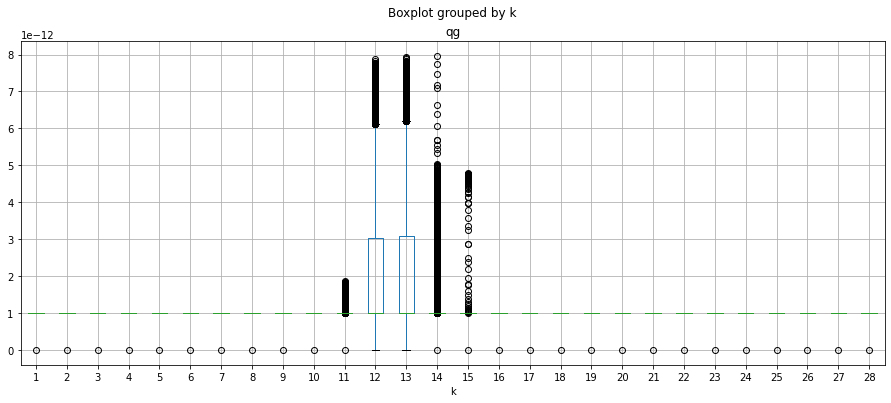

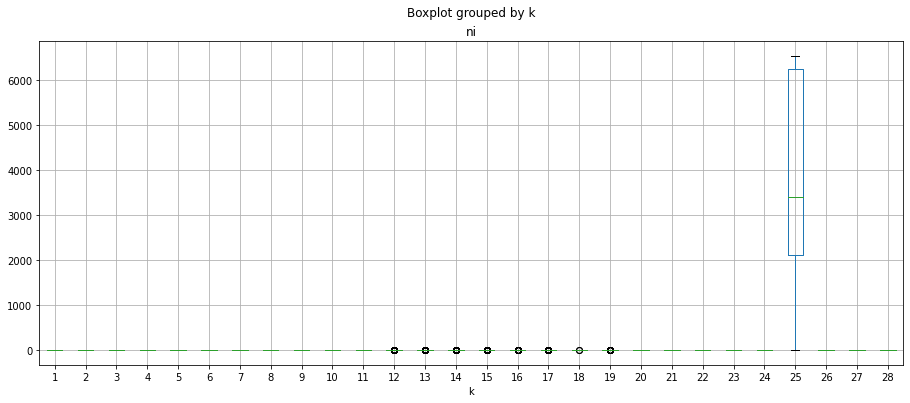

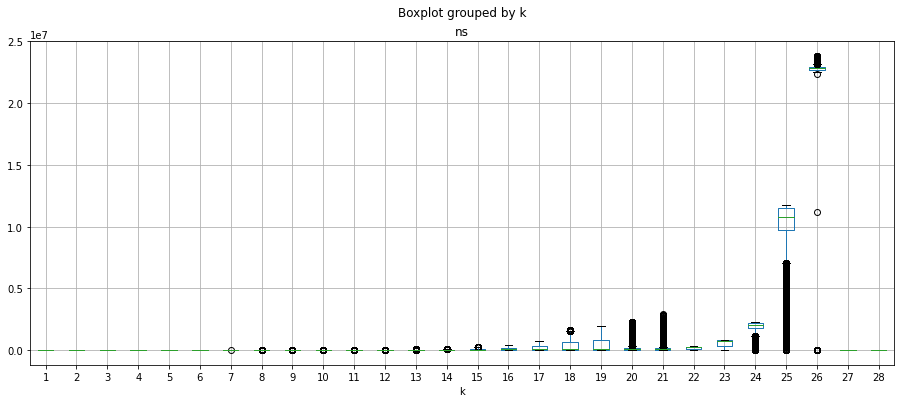

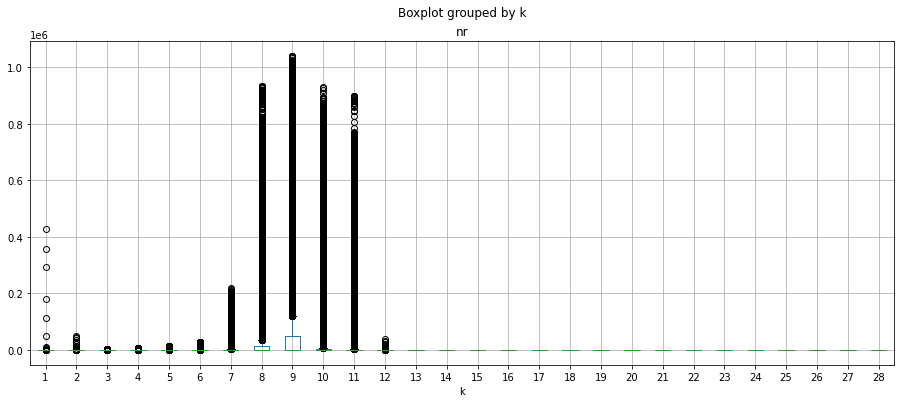

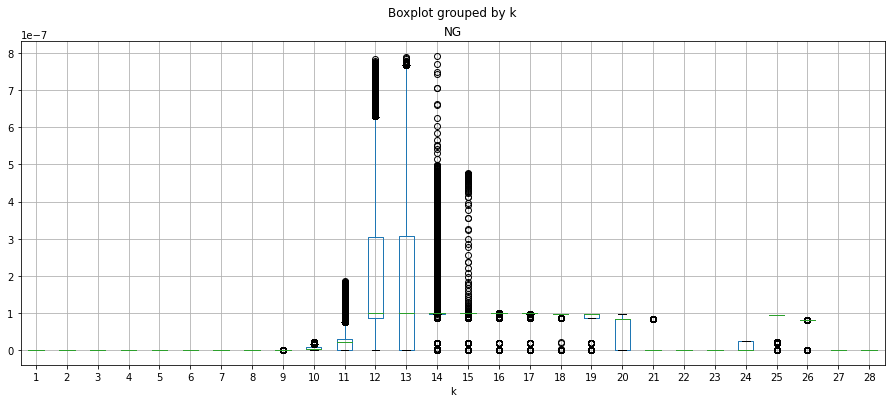

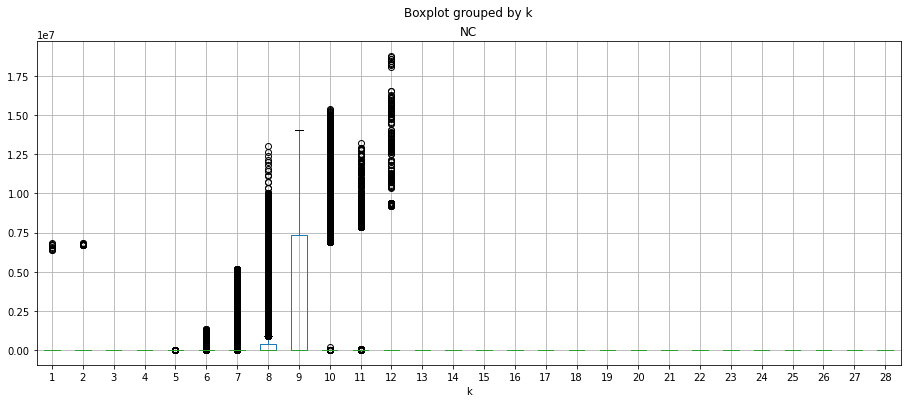

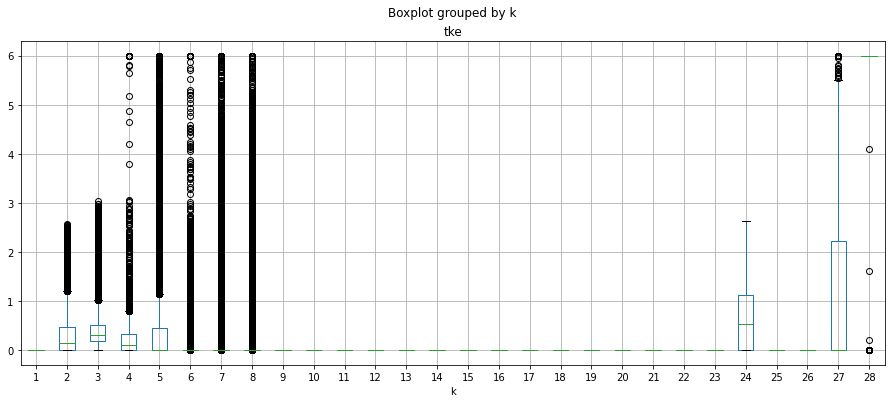

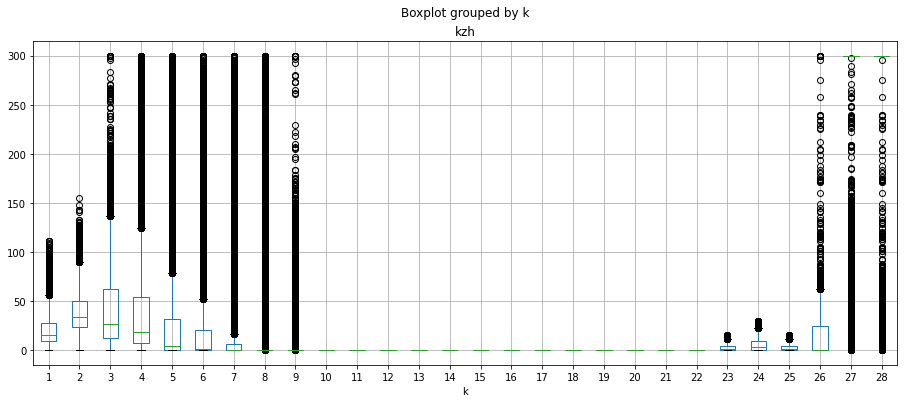

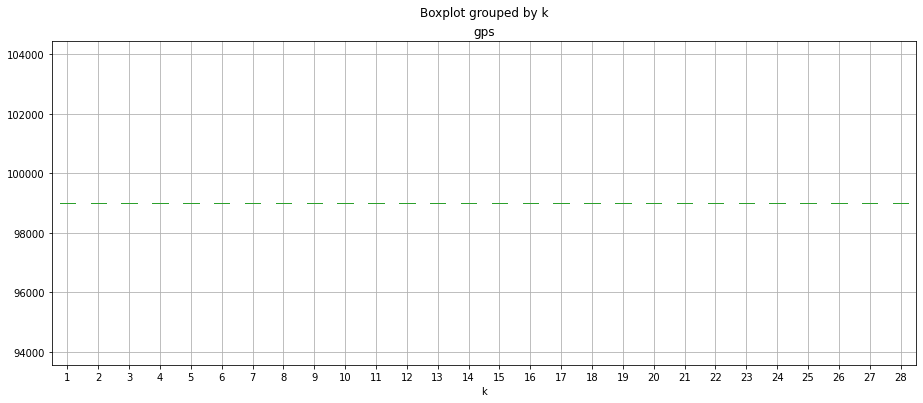

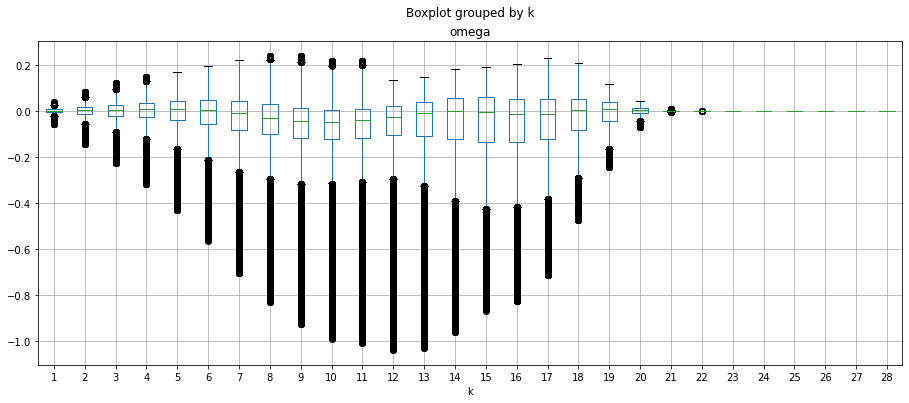

In [9]:
# Boxplot of variables through levels

for key in original_input_df.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    original_input_df.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()


### Boxplot das variáveis de saída, por níveis

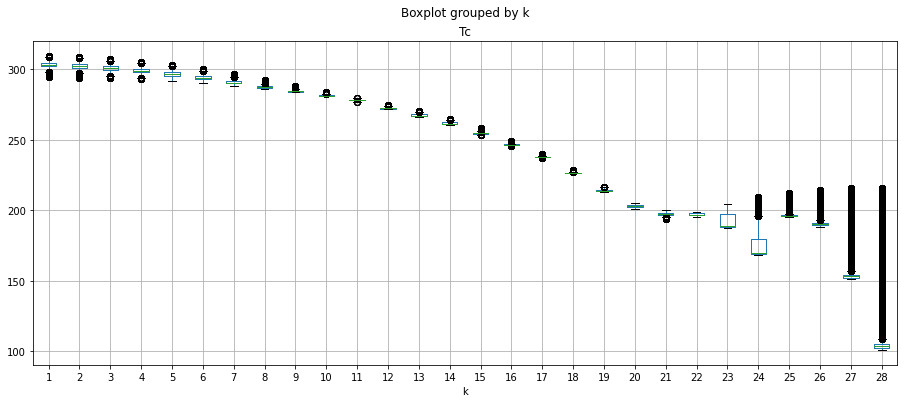

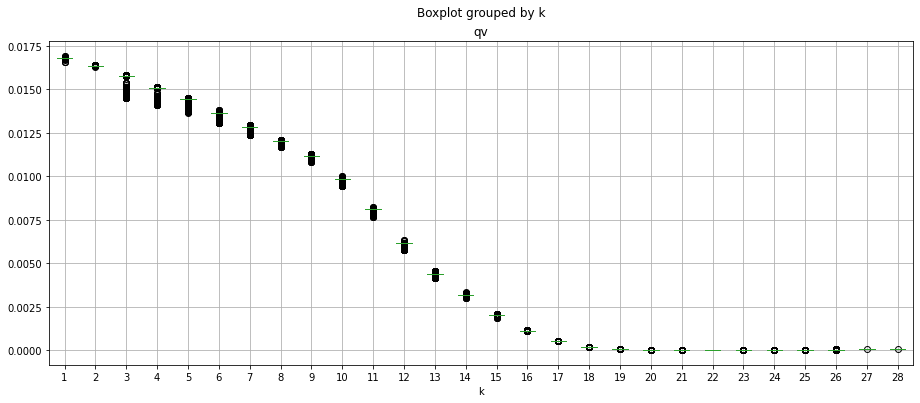

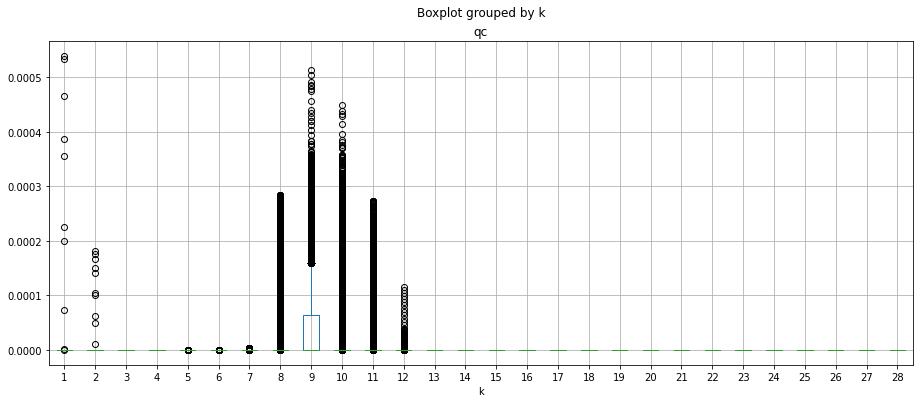

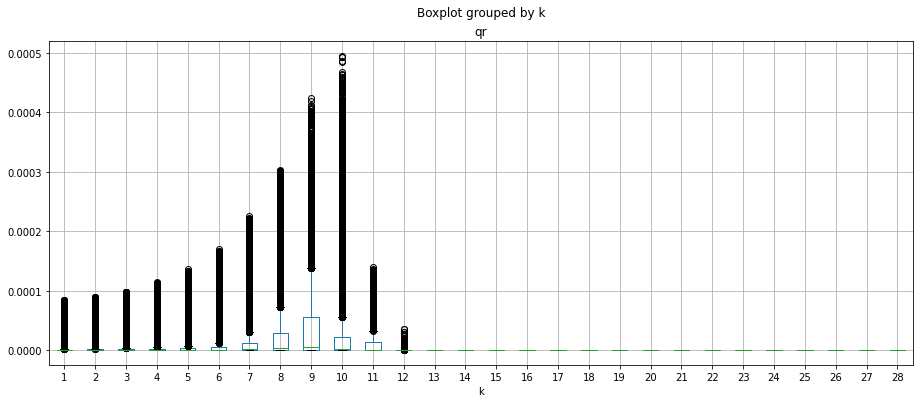

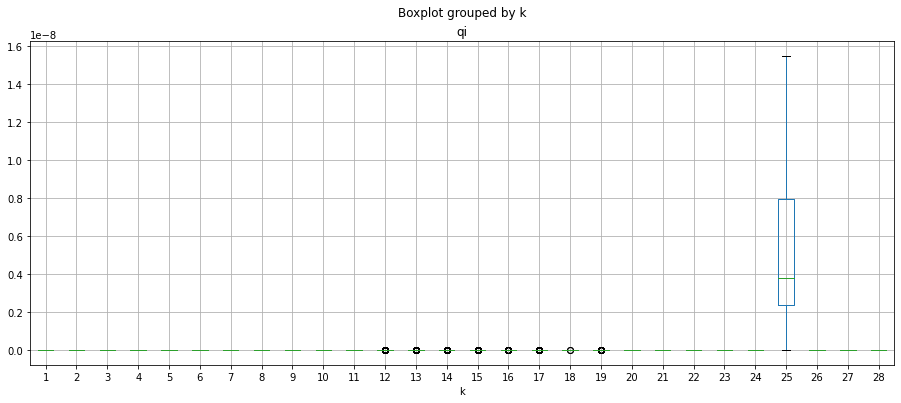

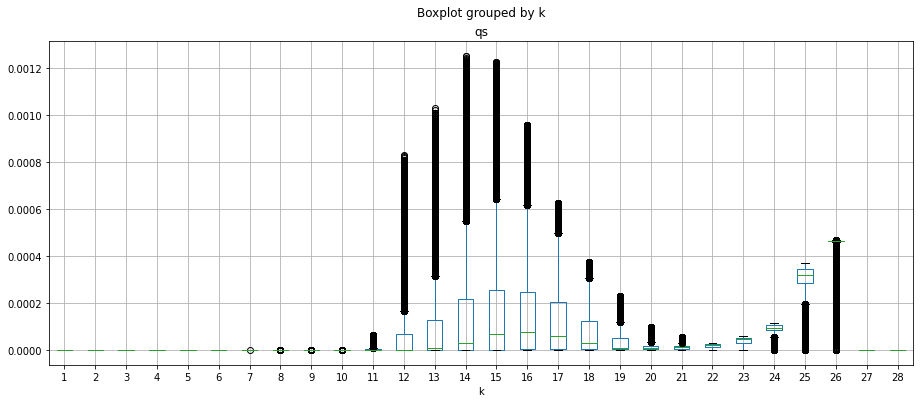

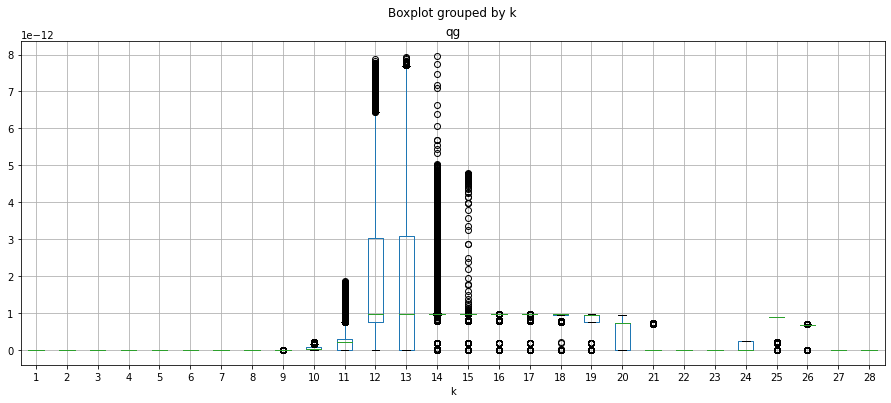

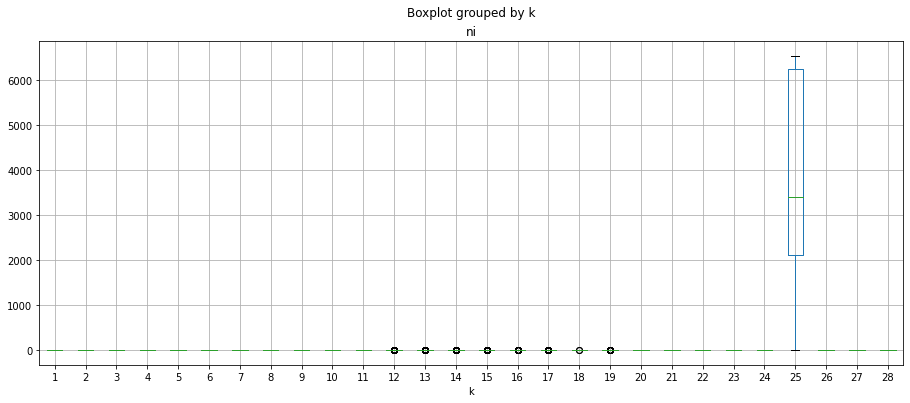

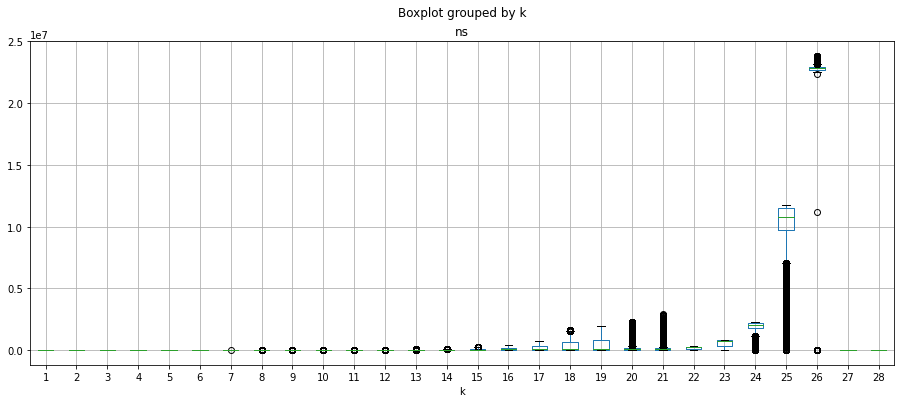

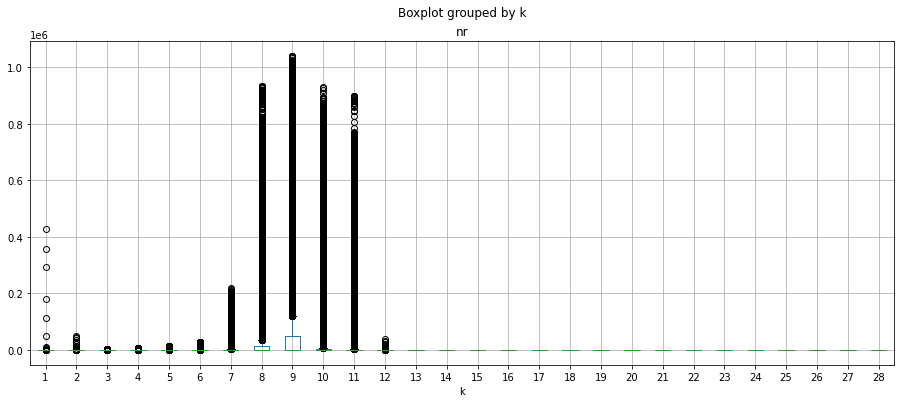

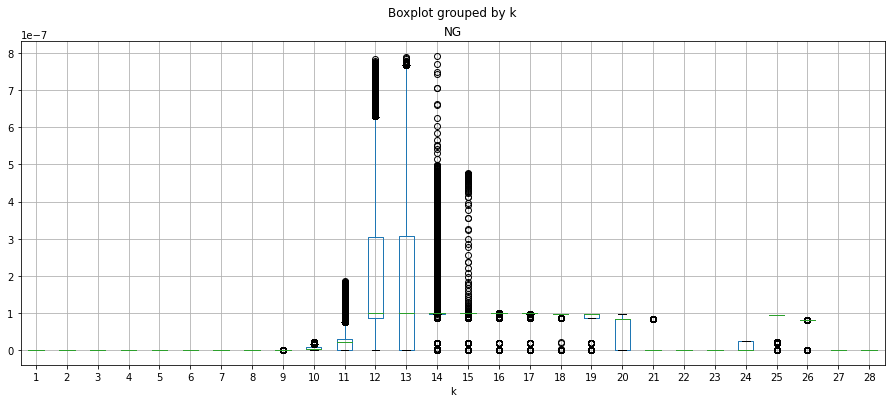

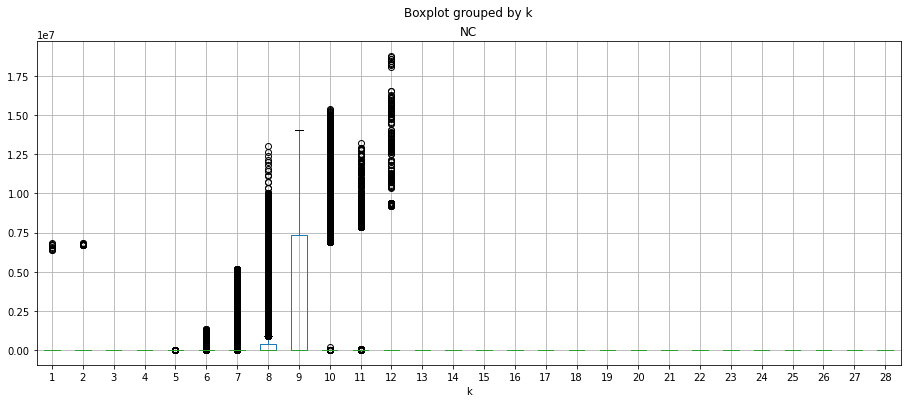

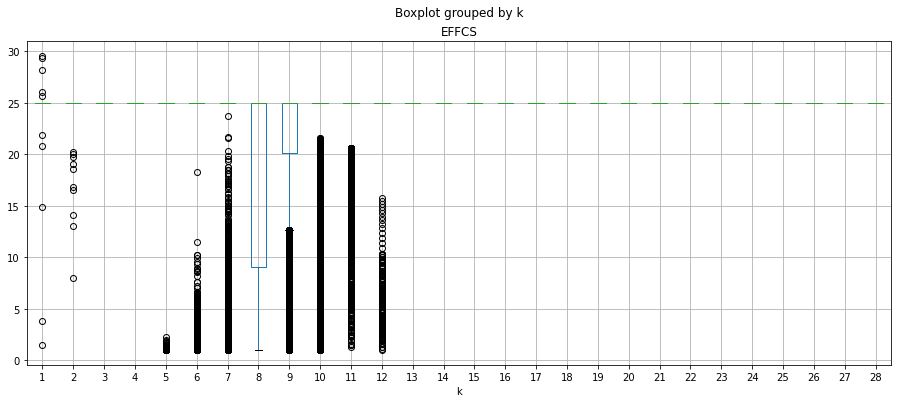

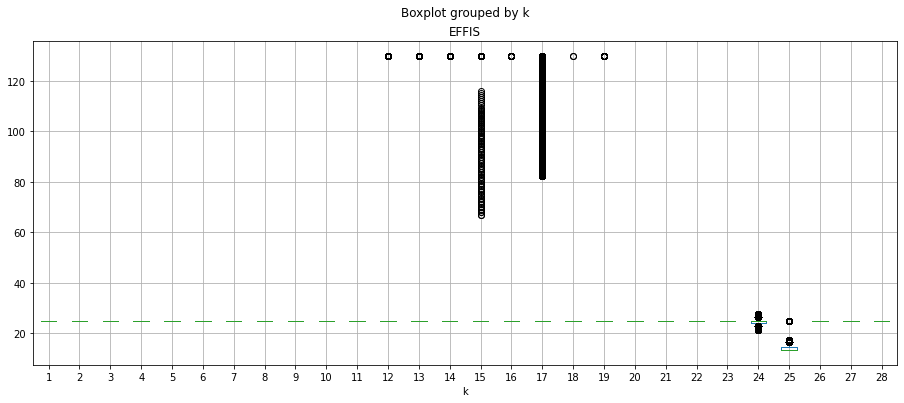

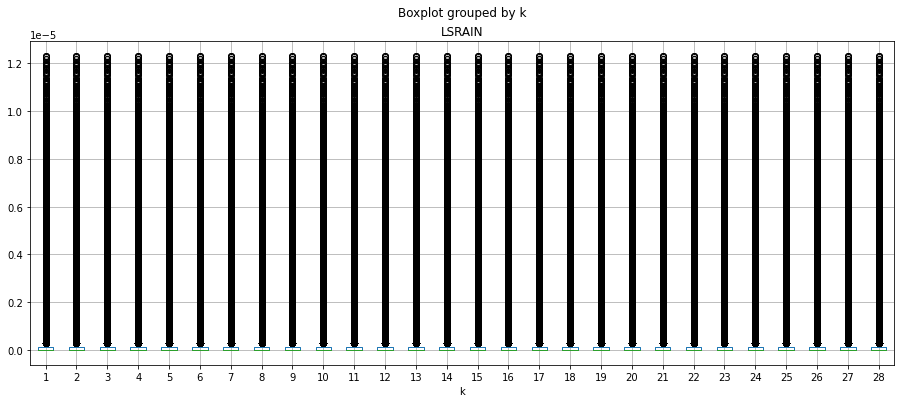

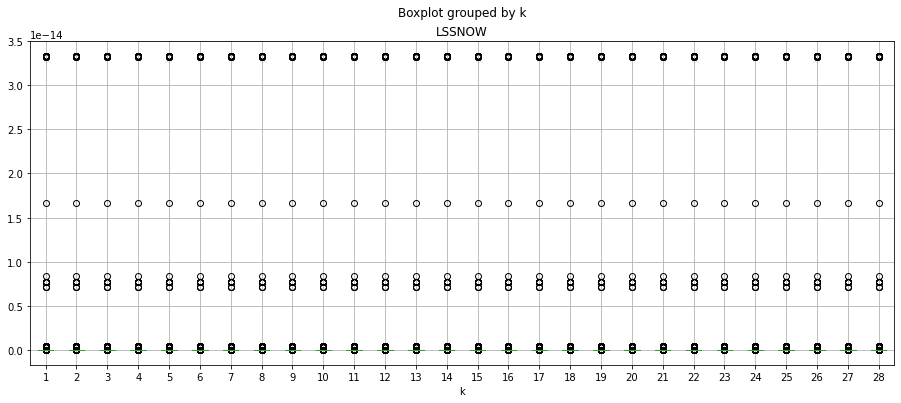

In [10]:
# Boxplot of variables through levels

for key in original_output_df.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    original_output_df.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()

### Gráfico de perfil vertical das variáves de entrada em 3 timesteps

In [11]:
# Plot the vertical levels of first, 100th and last timestep

# first_timestep_input_df = original_input_df.head(28)
# med_timestep_input_df = original_input_df.loc[2800:2800+27]
# last_timestep_input_df = original_input_df.tail(28)

# idx_plot = 1
# plt.figure(figsize=(10, 10))
# for key in last_timestep_input_df.columns.tolist():
#     plt.subplot(7, 3, idx_plot)
#     plt.ylabel("k")
#     plt.xlabel(key)
#     plt.plot(first_timestep_input_df[key], first_timestep_input_df[["k"]], label="first timestep")
#     plt.plot(med_timestep_input_df[key], med_timestep_input_df[["k"]], label="100th timestep")
#     plt.plot(last_timestep_input_df[key], last_timestep_input_df[["k"]], label="last timestep")
#     idx_plot += 1
# plt.legend(loc="upper left")
# plt.subplots_adjust(hspace=1, wspace=1)
# plt.show()


# first_timestep_output_df = original_output_df.head(28)
# med_timestep_output_df = original_output_df.loc[2801:2801+27]
# last_timestep_output_df = original_output_df.tail(28)

# idx_plot = 1
# for key in last_timestep_output_df.columns.tolist():
#     plt.subplot(4, 6, idx_plot)
#     plt.ylabel("k")
#     plt.xlabel(key)
#     plt.title("Output x Level")
#     plt.plot(first_timestep_output_df[key], first_timestep_output_df[["k"]], label="first timestep")
#     plt.plot(med_timestep_output_df[key], med_timestep_output_df[["k"]], label="100th timestep")
#     plt.plot(last_timestep_output_df[key], last_timestep_output_df[["k"]], label="last timestep")
#     plt.legend()
# plt.show()

## Pré-processando a entrada (exemplos) e saídas (metas)
- Selecionamos as primeiras variáveis de entrada e saída que serão usadas no treinamento e na validação;
- também podemos criar novas variáveis como um composto de variáveis

In [12]:
def preprocess_features(input_df):
  """Prepares input features input_df

  Args:
    input data frame: A Pandas DataFrame expected to contain data from input data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
# All input variables
# "k", "si", "si_kmax_+_1", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "gps", "omega"    
  selected_features = input_df[
    [
    "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"    
    ]]
  processed_features = selected_features.copy()
  return processed_features


def preprocess_targets(output_df):
  """Prepares target features (i.e., labels) from output_df

  Args:
    output_df: A Pandas DataFrame expected to contain data from output data set.
  Returns:
    A DataFrame that contains the target features.
  """
# All output variables
# "k", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
  output_targets = output_df [
      [
      "k", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
      ]
  ]
  return output_targets


# execute the pre processing
all_examples = preprocess_features(original_input_df)
all_targets = preprocess_targets(original_output_df)


### Funções de normalização

In [34]:
# Linear normalization (serie or numpy 1D array)
def linear_scale(serie_or_np_arr):
  min_val = serie_or_np_arr.min()
  max_val = serie_or_np_arr.max()
  scale = (max_val - min_val) / 2.0
  y = lambda x:((x - min_val) / scale) - 1.0
  return y(serie_or_np_arr), min_val, max_val


# Linear denormalization (serie or numpy 1D array)
#
# enter with min and max val of values before normalization
def delinear_scale(serie_or_np_arr, min_val, max_val):
  scale = (max_val - min_val) / 2.0
  y = lambda x:((x + 1.0) * scale) + min_val
  return y(serie_or_np_arr)


# Different normalilzation functions

def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

### Normalização da base usando escala linear

Normalização das entradas para a escala -1, 1. para os primeiros testes

Como regra geral, o NN treina melhor quando os recursos de entrada estão aproximadamente na mesma escala.

Isso ajuda o NN a não ficar preso em etapas que são muito grandes em uma dimensão ou muito pequenas em outra.


In [36]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""

  # Convert pandas data into a dict of np arrays.
  processed_features = examples_dataframe.copy()
  minvalues = {}
  maxvalues = {}
  for key,value in dict(examples_dataframe).items():
    if key != 'k':
      processed_features[key], minvalues[key], maxvalues[key] = linear_scale(value)
  return processed_features, minvalues, maxvalues


#### Boxplot das variáveis de entrada linearmente normalizadas

All normalized examples summary:


k             si  ...            kzh          omega
count 1592668.000000 1592668.000000  ... 1592668.000000 1592668.000000
mean       14.500000      -0.066812  ...      -0.827102       0.574894
std         8.077750       0.729799  ...       0.477812       0.194575
min         1.000000      -1.000000  ...      -1.000000      -1.000000
25%         7.750000      -0.798840  ...      -0.999533       0.573869
50%        14.500000      -0.139702  ...      -0.999533       0.624689
75%        21.250000       0.667721  ...      -0.941476       0.645784
max        28.000000       1.000000  ...       1.000000       1.000000

[8 rows x 18 columns]

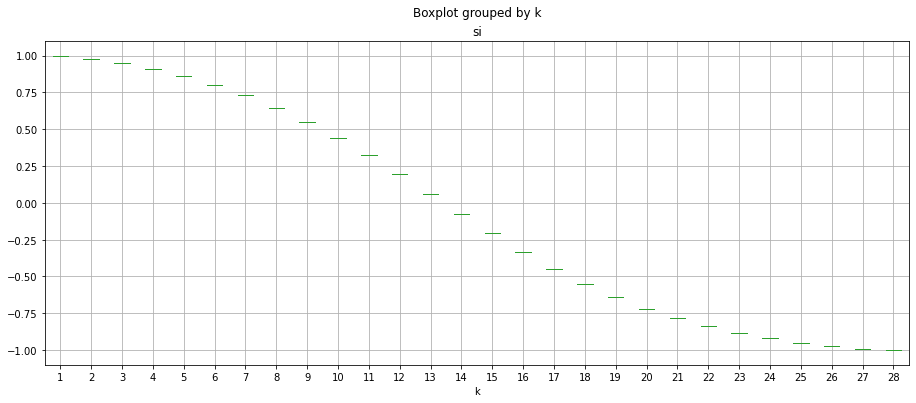

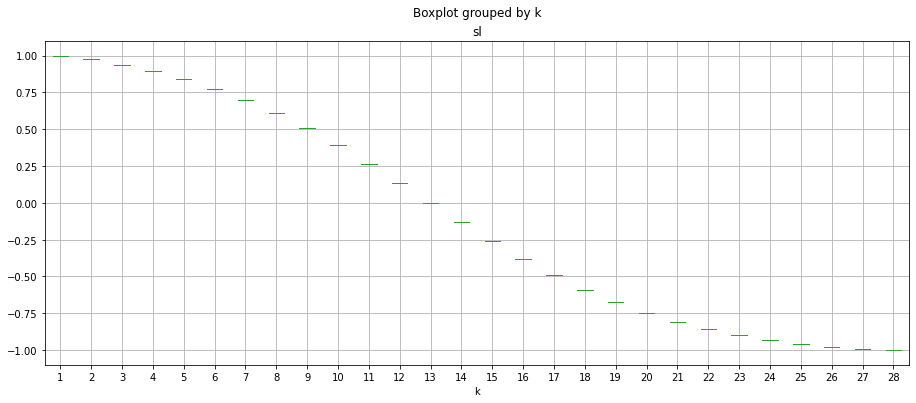

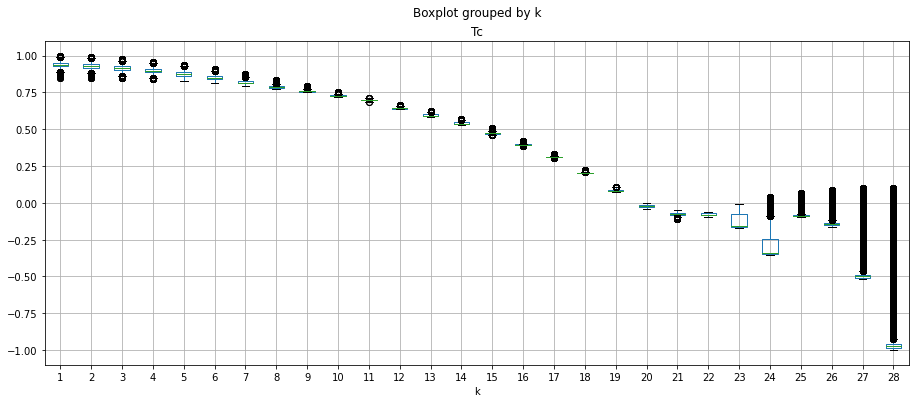

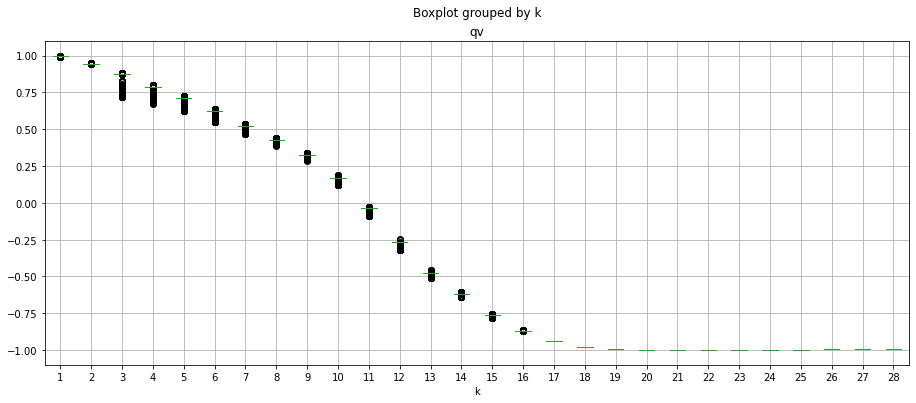

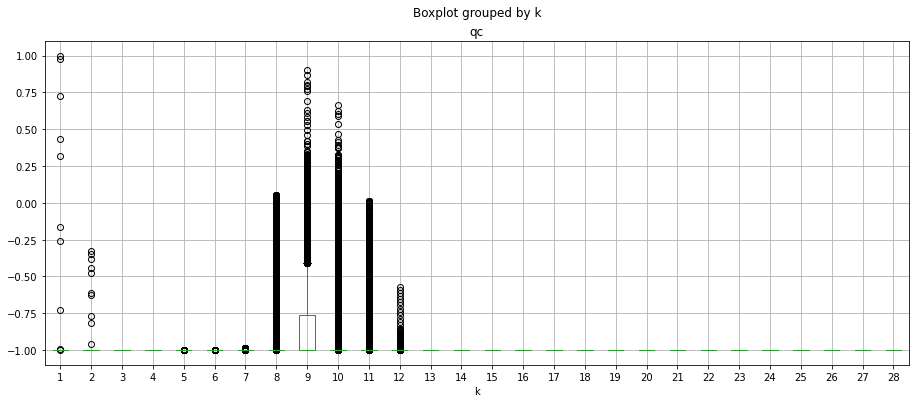

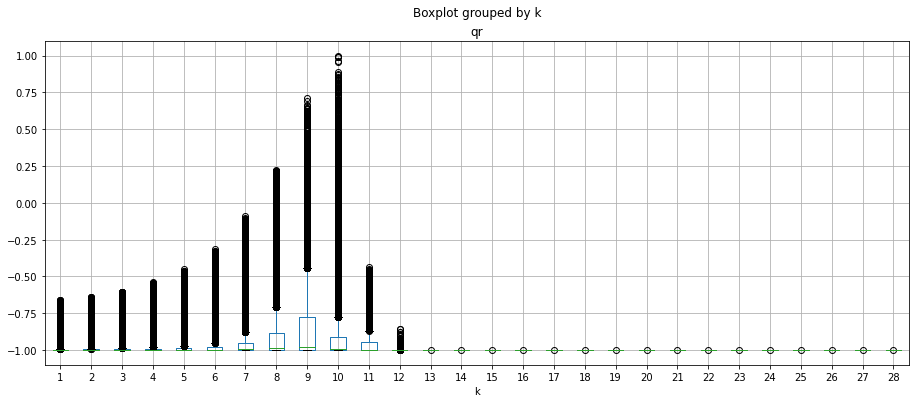

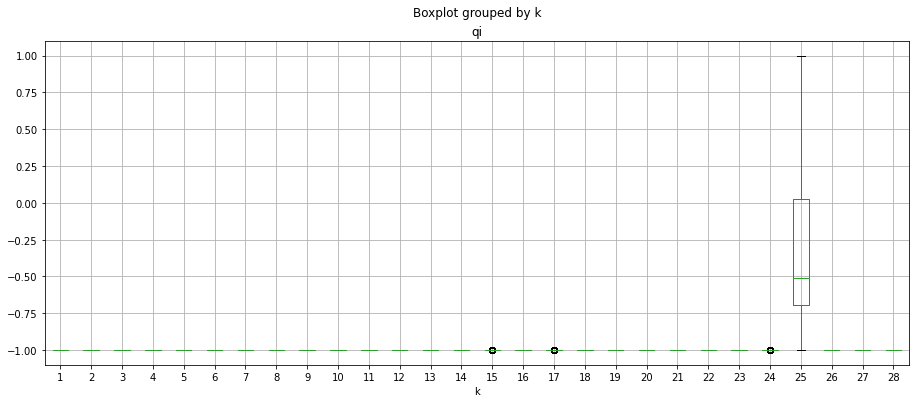

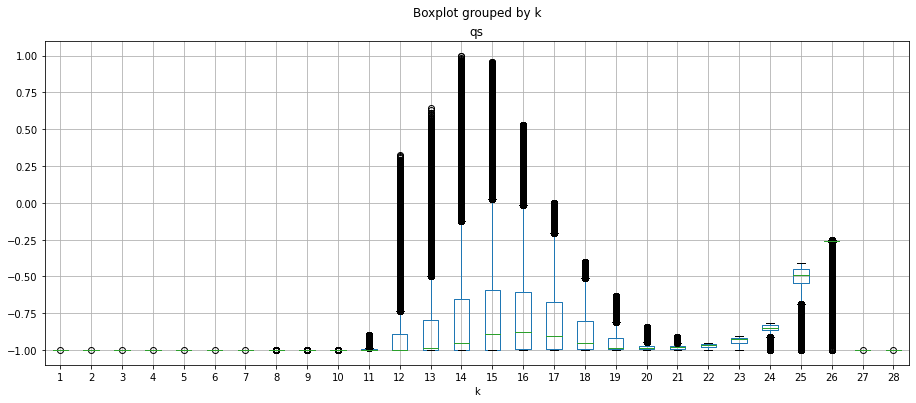

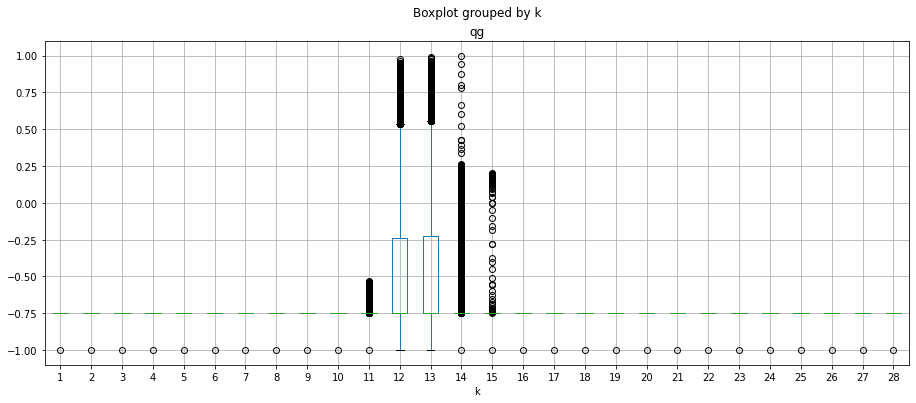

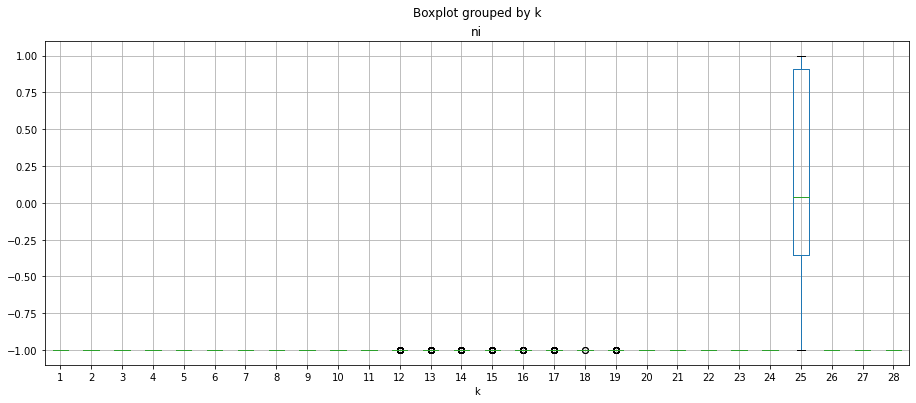

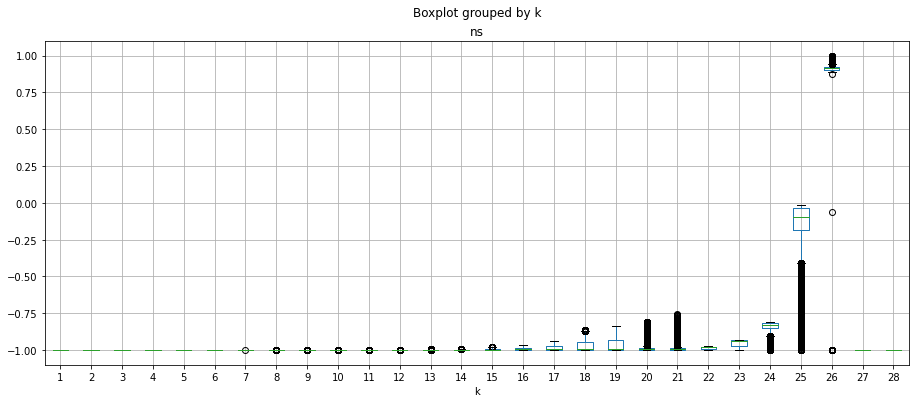

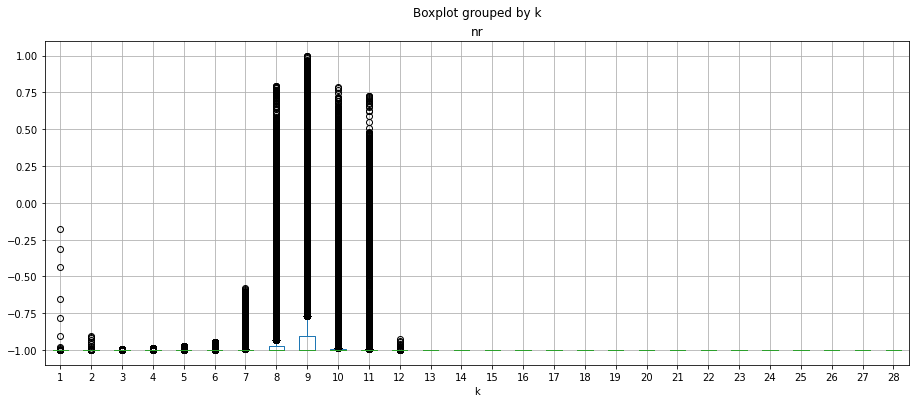

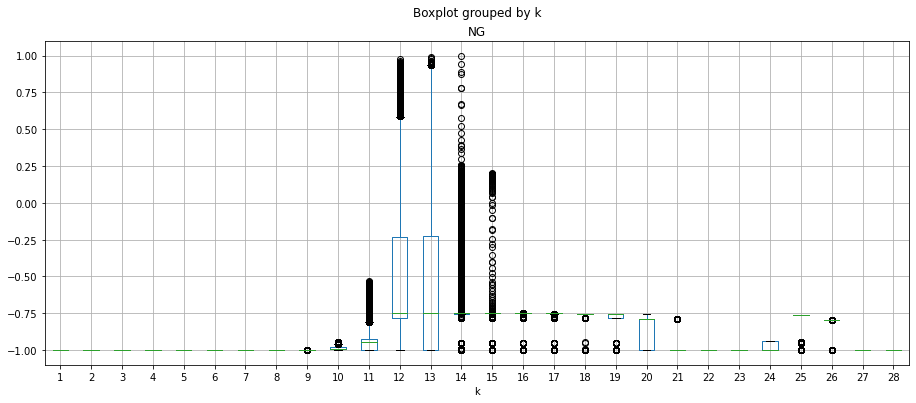

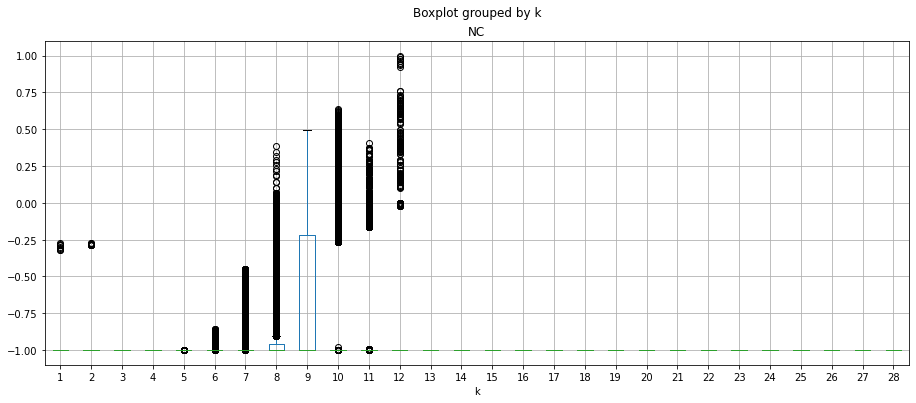

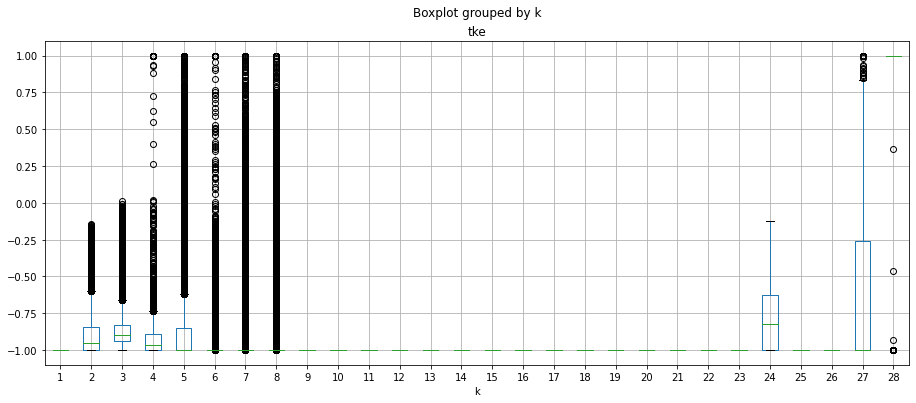

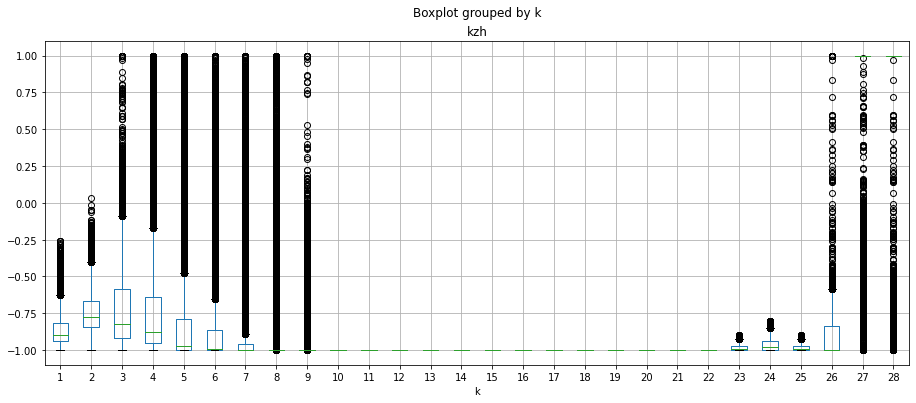

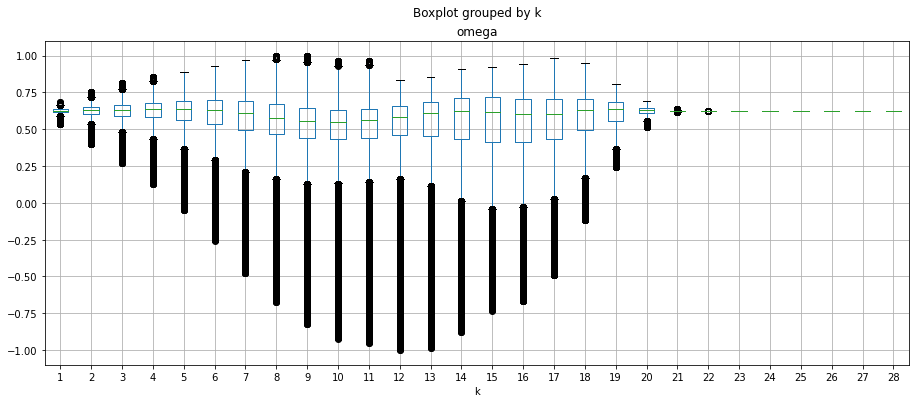

In [15]:
#
# code below just to show
#

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)

print("All normalized examples summary:")
display.display(normalized_all_examples.describe())

# Boxplot of variables through levels
for key in normalized_all_examples.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    normalized_all_examples.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()

#### Boxplot das variáveis de saída linearmente normalizadas

All normalized targets summary:


k             Tc  ...         LSRAIN         LSSNOW
count 1592668.000000 1592668.000000  ... 1592668.000000 1592668.000000
mean       14.500000       0.368241  ...      -0.928354      -0.999356
std         8.077750       0.491957  ...       0.216745       0.032288
min         1.000000      -1.000000  ...      -1.000000      -1.000000
25%         7.750000      -0.070200  ...      -1.000000      -1.000000
50%        14.500000       0.517579  ...      -0.999391      -1.000000
75%        21.250000       0.806018  ...      -0.981839      -1.000000
max        28.000000       1.000000  ...       1.000000       1.000000

[8 rows x 17 columns]

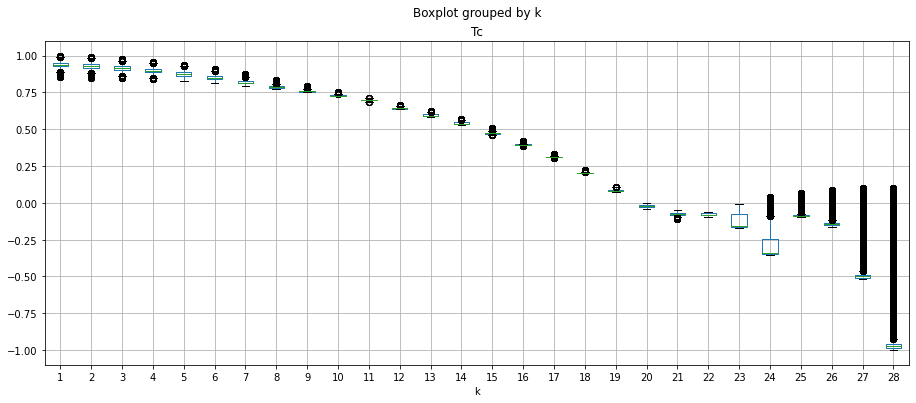

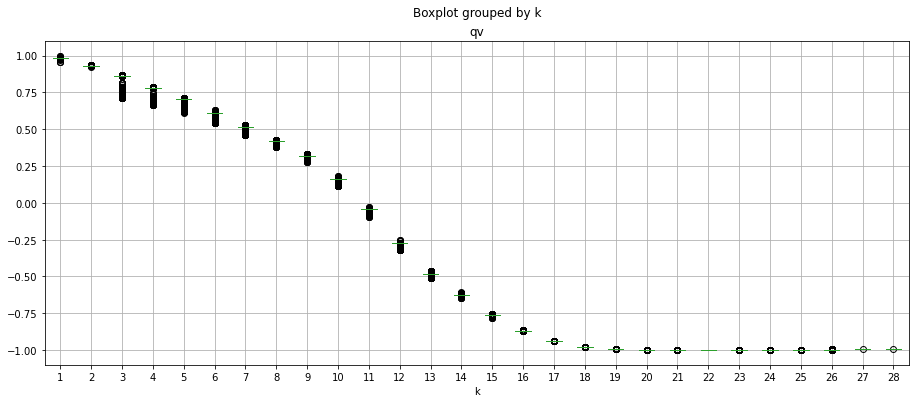

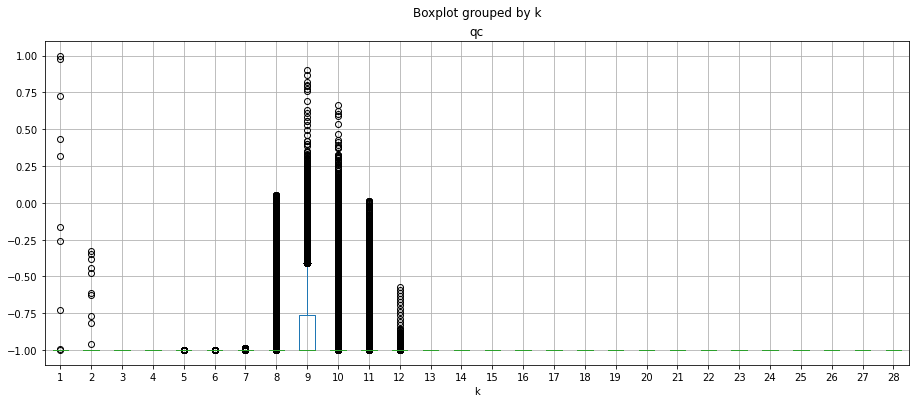

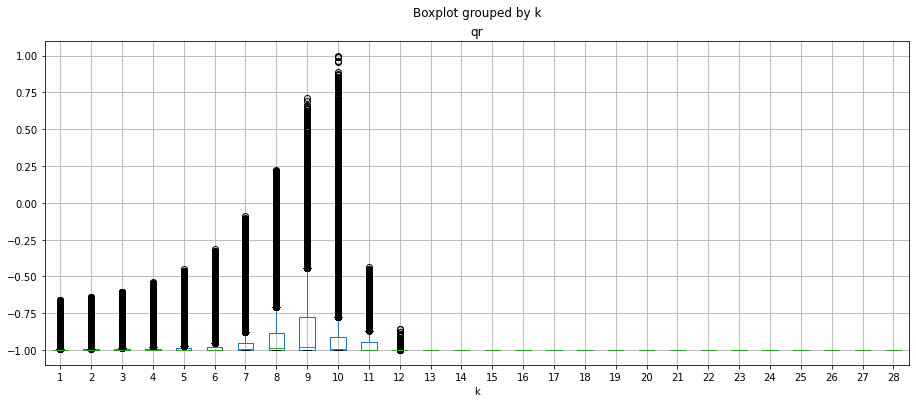

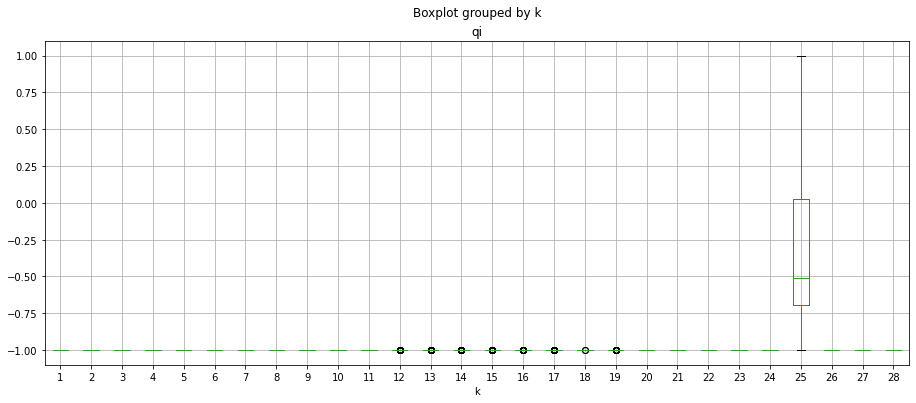

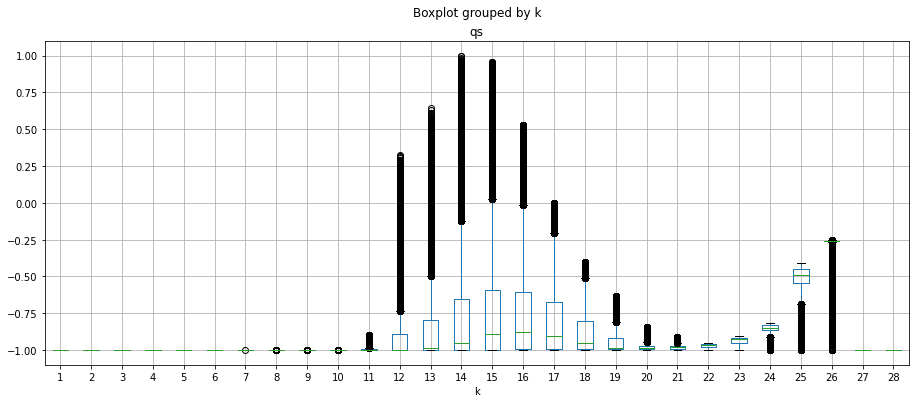

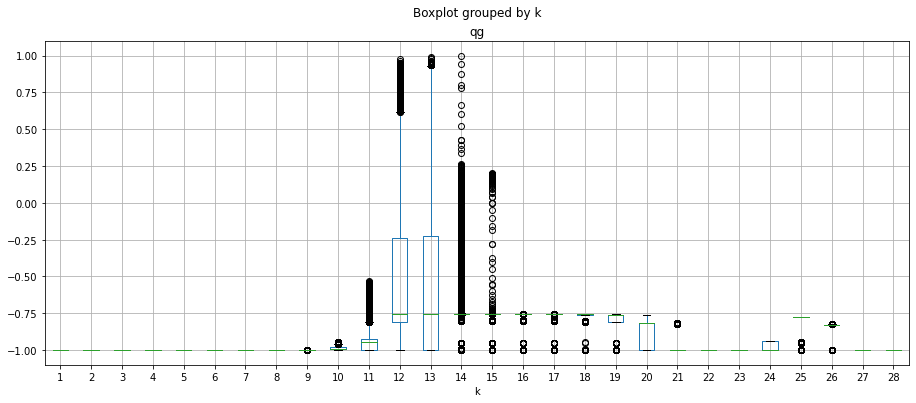

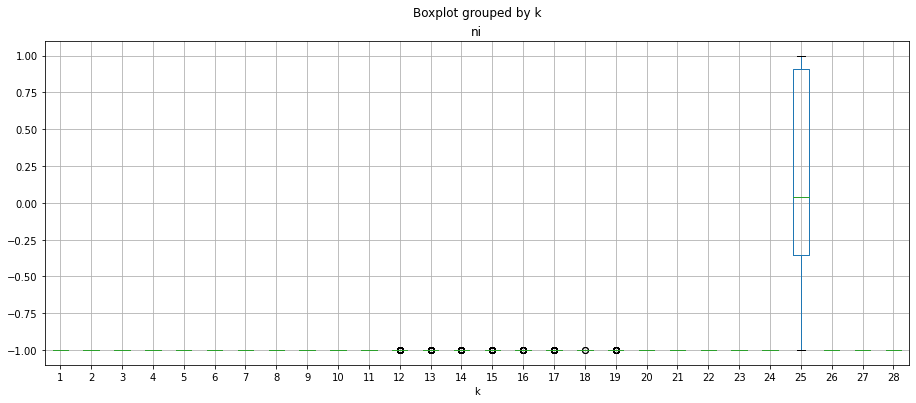

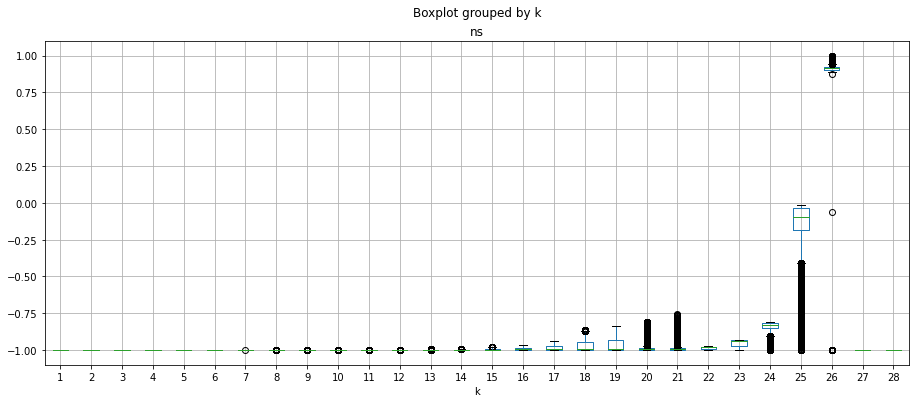

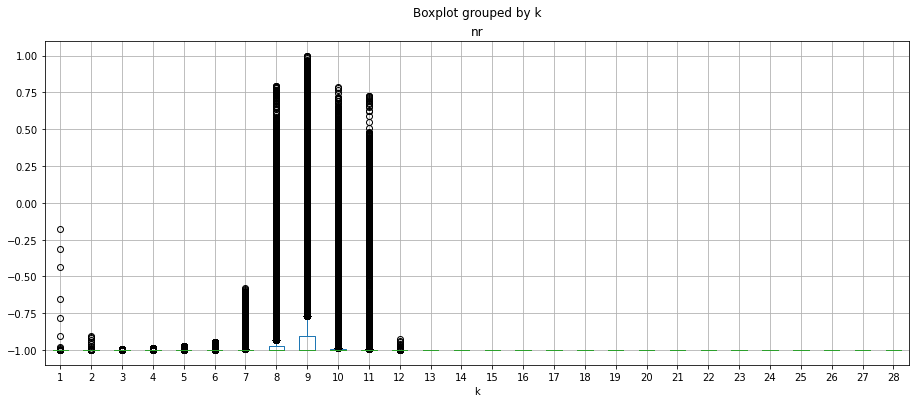

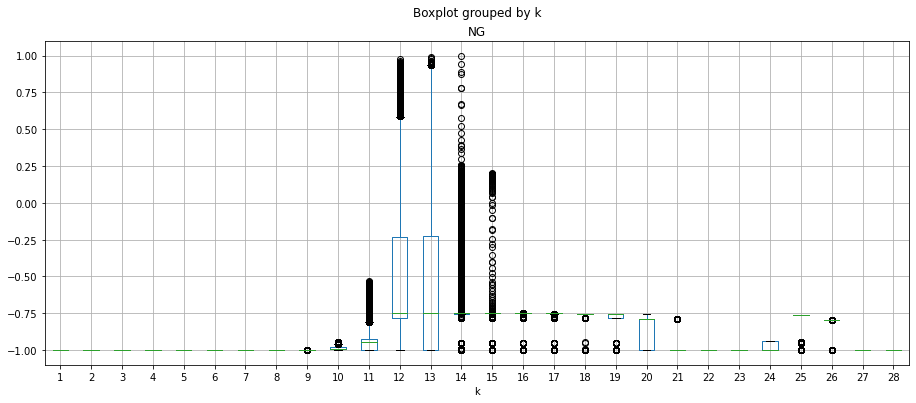

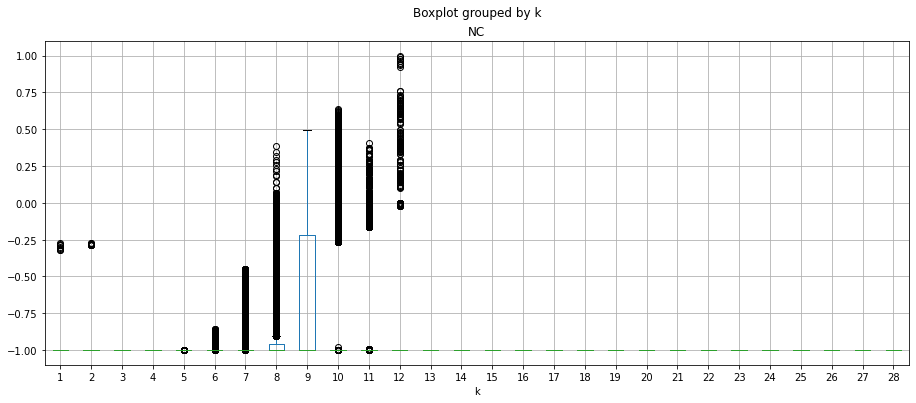

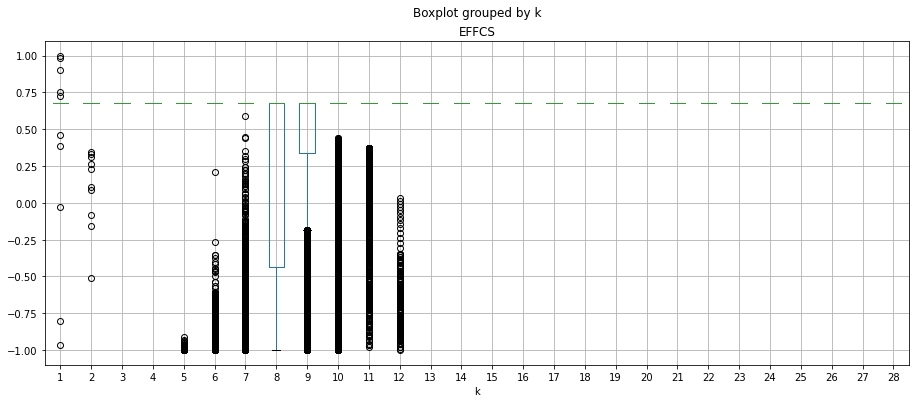

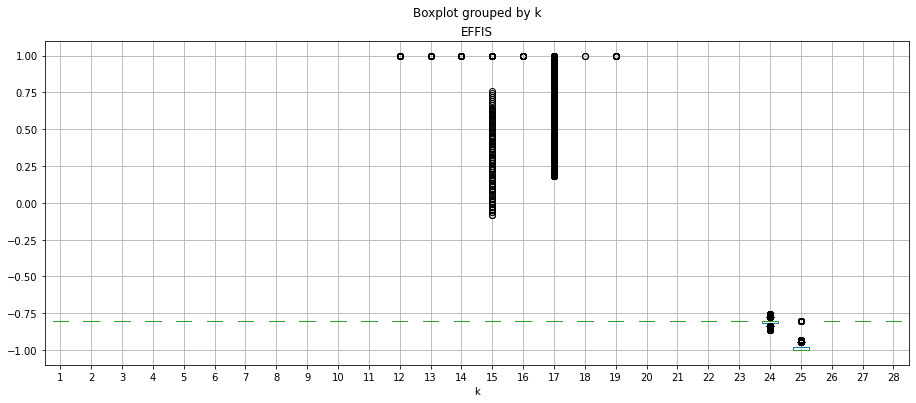

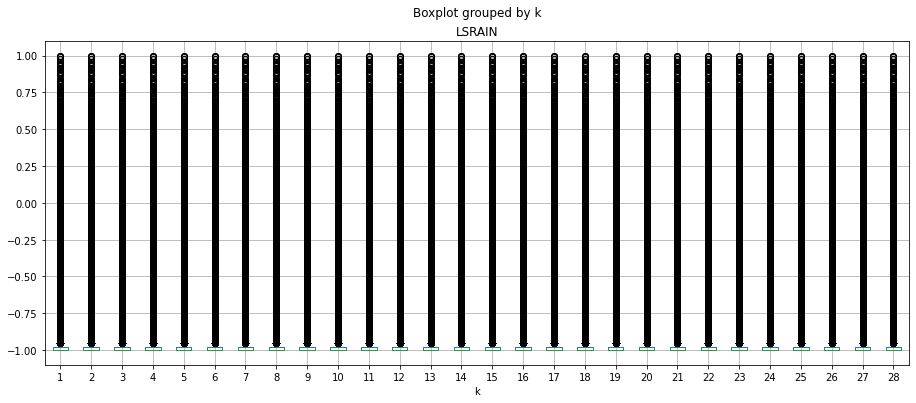

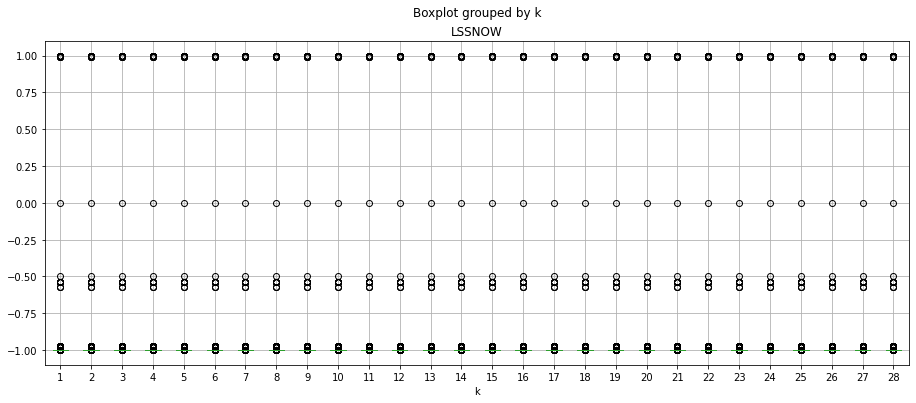

In [16]:
#
# code below just to show
#

normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

print("All normalized targets summary:")
display.display(normalized_all_targets.describe())

# Boxplot of variables through levels
for key in normalized_all_targets.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    normalized_all_targets.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()

### Normalização da base usando diferentes escalas para cada variável

- Diferentes normalizações por variável, como linear, logarítimica e z-score


In [17]:
def normalize_examples(examples_dataframe):
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"
  processed_features = pd.DataFrame()

  if len(examples_dataframe["k"]) > 0:
    processed_features["k"] = examples_dataframe["k"]

  for m_var in [ "si", "sl", "Tc", "qv"]:
    processed_features[m_var], scales_dummy = linear_scale(examples_dataframe[m_var])

  for m_var in [ "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh"]:
    processed_features[m_var] = log_normalize(examples_dataframe[m_var])

  processed_features["omega"] = z_score_normalize(examples_dataframe["omega"])
  # processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
    
  return processed_features


#### Boxplot das variáveis de entrada com diferentes normalizações

All normalized examples summary:


k             si  ...            kzh          omega
count 1592668.000000 1592668.000000  ... 1592668.000000 1592668.000000
mean       14.500000      -0.066812  ...       1.198691      -0.000000
std         8.077750       0.729799  ...       1.768879       1.000000
min         1.000000      -1.000000  ...       0.029559      -8.094028
25%         7.750000      -0.798840  ...       0.095310      -0.005265
50%        14.500000      -0.139702  ...       0.095310       0.255916
75%        21.250000       0.667721  ...       2.283175       0.364331
max        28.000000       1.000000  ...       5.707110       2.184796

[8 rows x 18 columns]

All normalized targets summary:


k             Tc  ...         LSRAIN         LSSNOW
count 1592668.000000 1592668.000000  ... 1592668.000000 1592668.000000
mean       14.500000       0.368241  ...      -0.928354      -0.999356
std         8.077750       0.491957  ...       0.216745       0.032288
min         1.000000      -1.000000  ...      -1.000000      -1.000000
25%         7.750000      -0.070200  ...      -1.000000      -1.000000
50%        14.500000       0.517579  ...      -0.999391      -1.000000
75%        21.250000       0.806018  ...      -0.981839      -1.000000
max        28.000000       1.000000  ...       1.000000       1.000000

[8 rows x 17 columns]

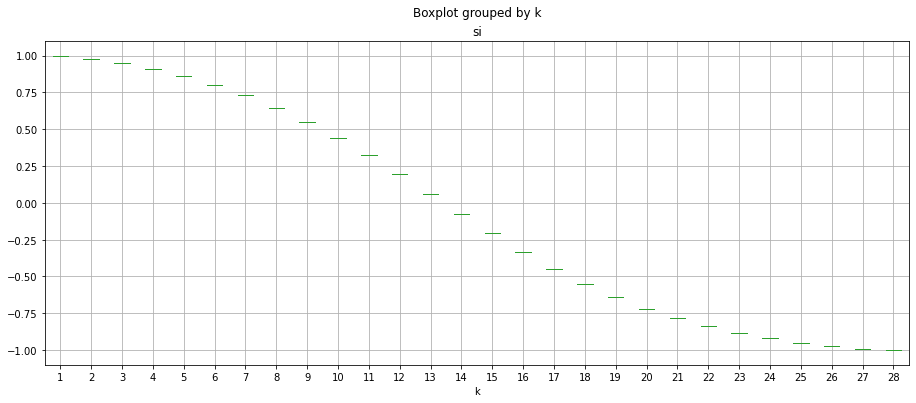

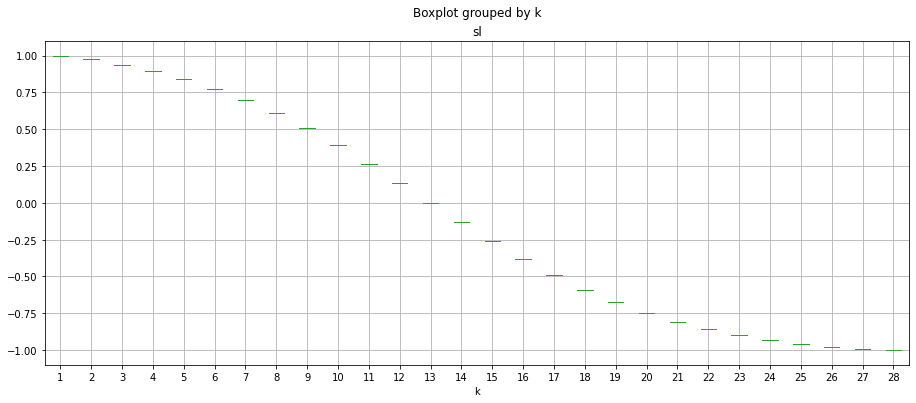

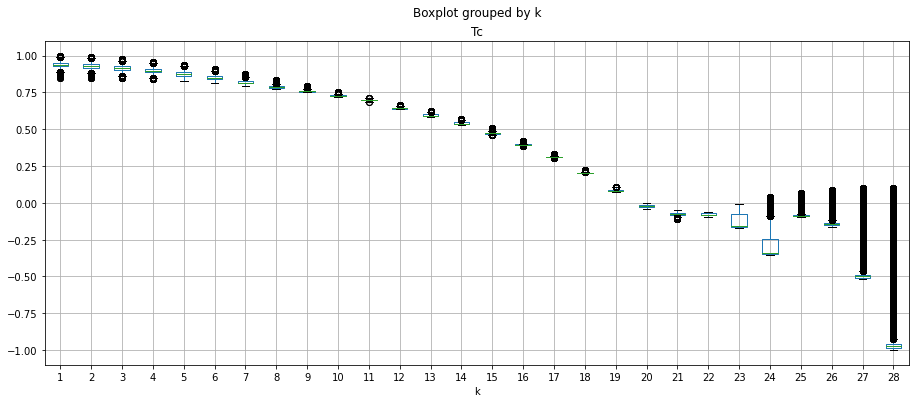

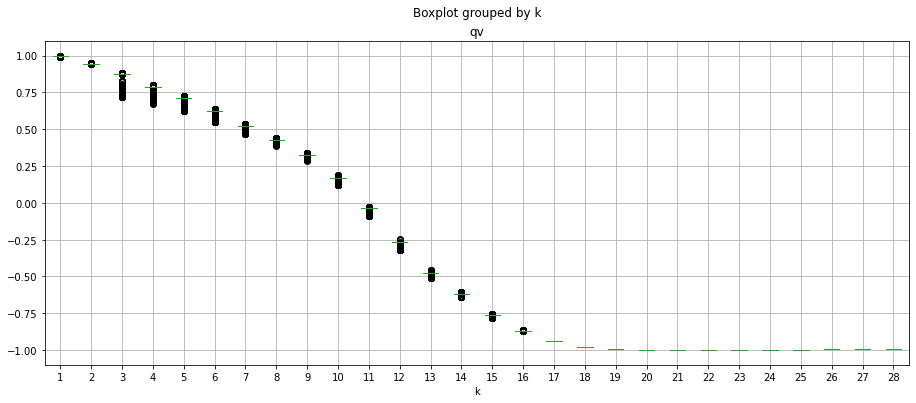

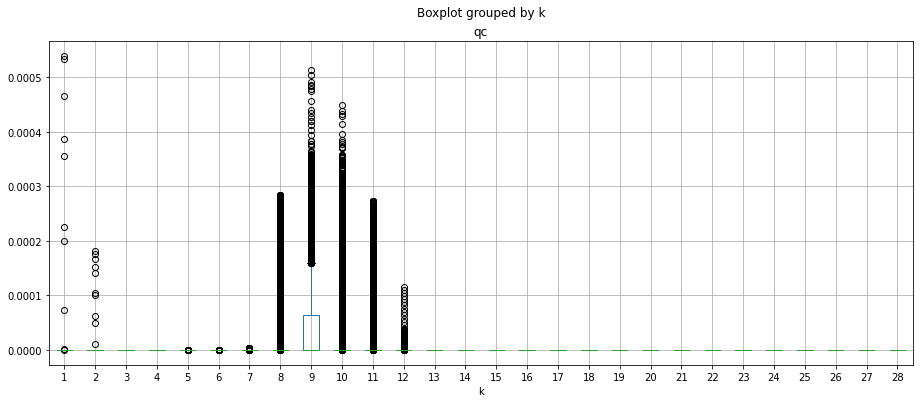

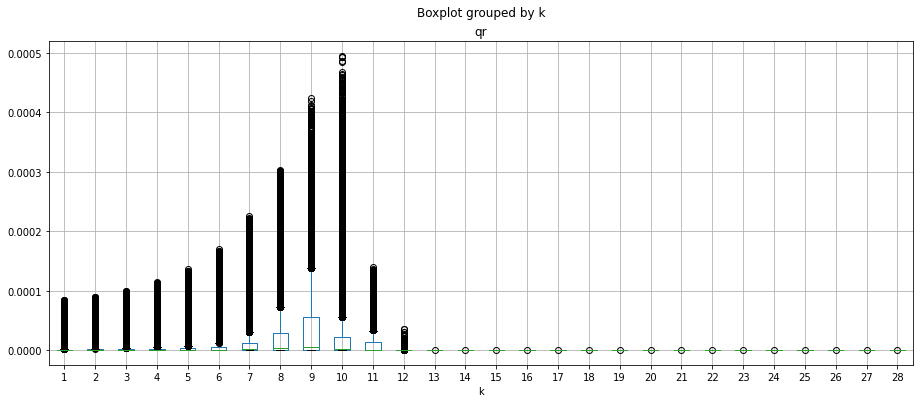

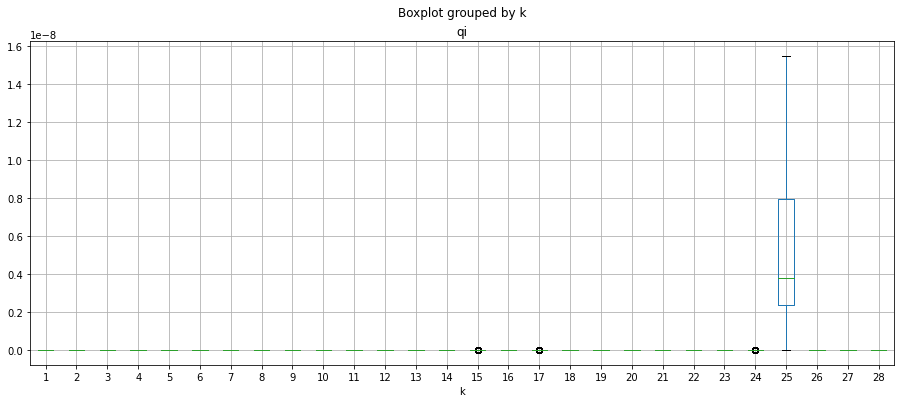

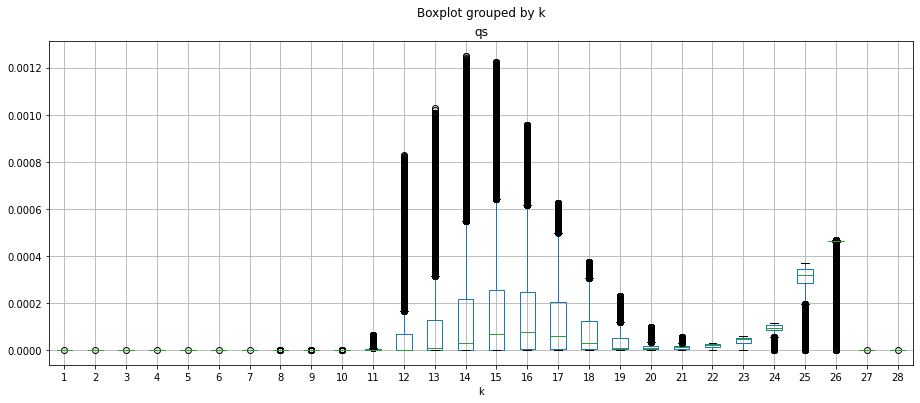

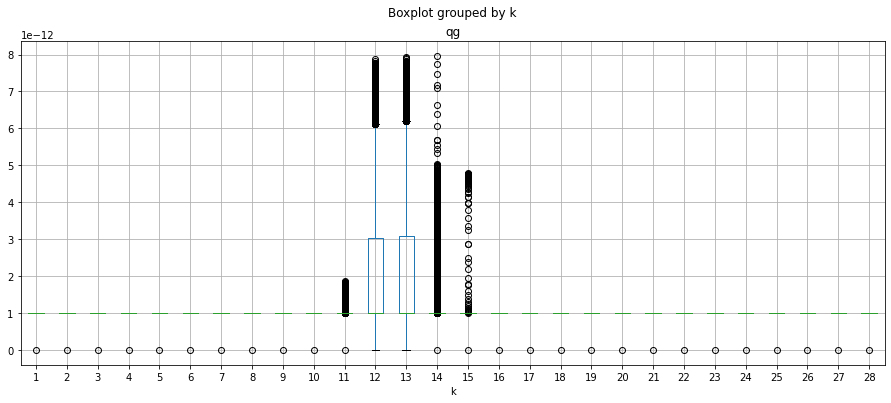

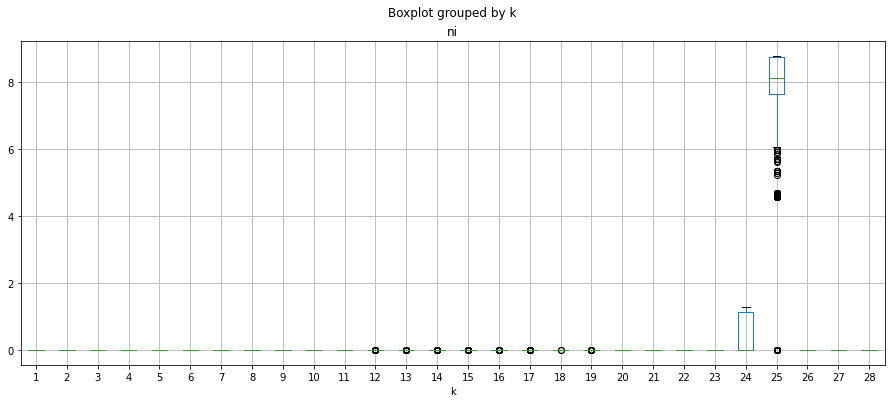

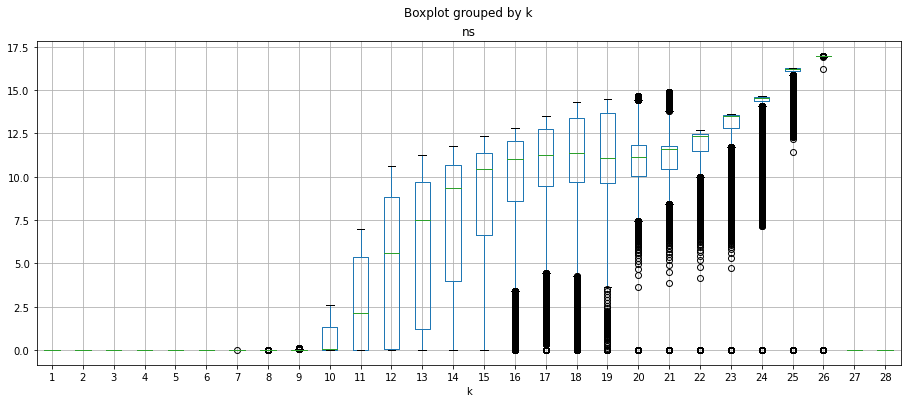

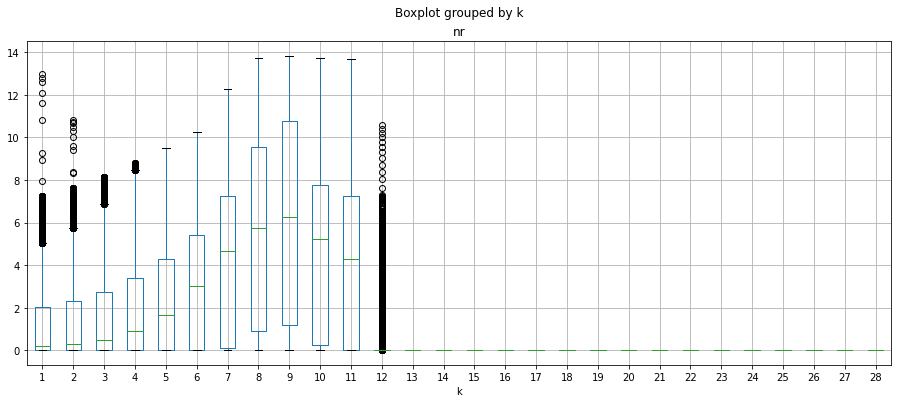

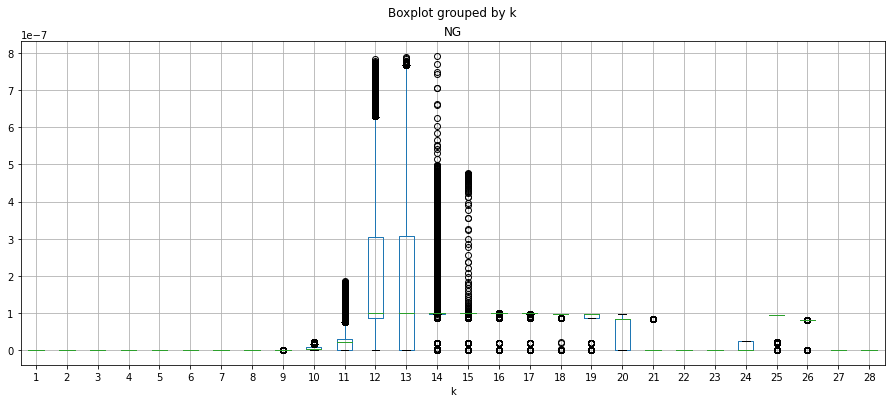

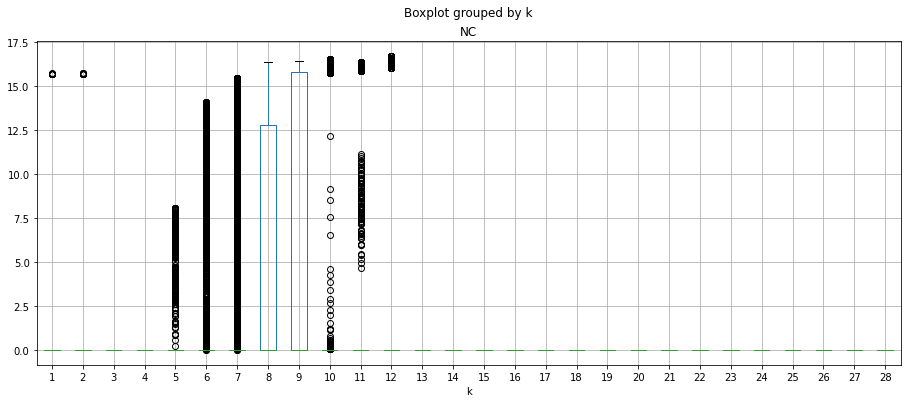

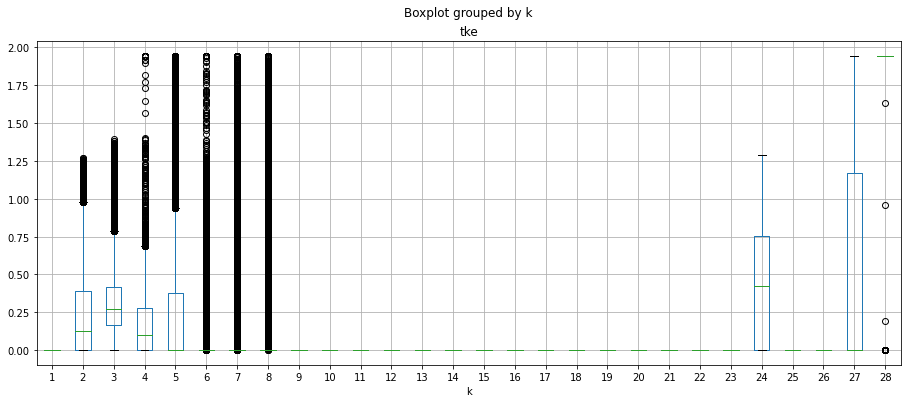

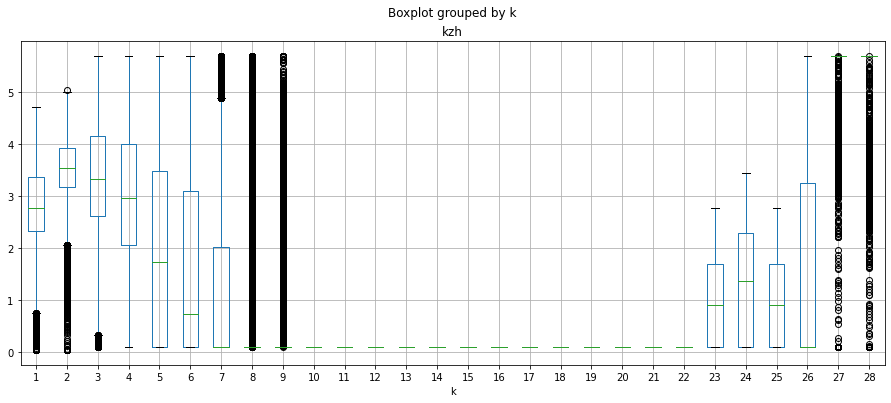

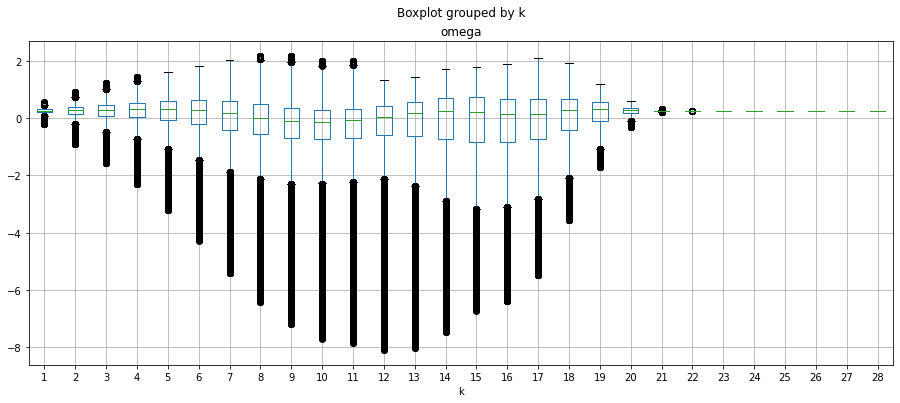

In [18]:

normalized_all_examples = normalize_examples(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

print("All normalized examples summary:")
display.display(normalized_all_examples.describe())

print("All normalized targets summary:")
display.display(normalized_all_targets.describe())


# Boxplot of variables through levels
for key in normalized_all_examples.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    normalized_all_examples.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()

## Amostras dos Conjuntos de treinamento e validação

Exibe  o resumo de entrada e saída de conjuntos de treinamento e validação, para verificar a homogeneidade desses conjuntos


In [19]:
def get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, train_percent_size):
  # Choose the first x percent for training.
  all_size = len(normalized_all_examples)
  train_size = int(all_size * train_percent_size / 28)*28
  print("train size = {}".format(train_size))

  normalized_training_examples = normalized_all_examples.head(train_size)
  normalized_training_targets = normalized_all_targets.head(train_size)

  # Choose the last (10%) (out of 265468) for validation.
  normalized_validation_examples = normalized_all_examples.iloc[train_size:]
  normalized_validation_targets = normalized_all_targets.iloc[train_size:]
  return normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets


def get_df_col_k(df_orig, k_inicial, k_final, dic_var_levs_exclude=None):
  df_col_k = pd.DataFrame()
  for k in range(k_inicial, k_final + 1):
    df = df_orig.copy()
    df_k = df[df['k'] == k]
    for col in df.columns.tolist():
      if col == 'k':
        continue
      if dic_var_levs_exclude is not None and col in dic_var_levs_exclude.keys():
        if k in dic_var_levs_exclude[col]:
          continue
      df_col_k['{}_k{}'.format(col, k)] = df_k[col].to_numpy()
  return df_col_k


def get_arr_2D_col_k(df_orig, colname, k_inicial, k_final):
  levels = k_final - k_inicial + 1
  rows_one_level = int(len(df_orig.index)/levels)
  arr_col_2d = np.zeros((rows_one_level, 28))

  for k in range(k_inicial, k_final + 1):
    df = df_orig.copy()
    df_k = df[df['k'] == k]
    arr_col_2d[:, k-1] = df_k[colname].to_numpy()
 
  return arr_col_2d

In [20]:
# Choose variables to train and validate
# Eliminate variables are not varying
# Separate 70% for training and 30# for validation

training_examples_tmp, training_targets_tmp, validation_examples_tmp, validation_targets_tmp = get_percent_normalized_trainining_and_validation(all_examples, all_targets, 0.7)

print("Training examples summary:")
display.display(training_examples_tmp.describe())

print("Validation examples summary:")
display.display(validation_examples_tmp.describe())

print("Training targets summary:")
display.display(training_targets_tmp.describe())

print("Validation targets summary:")
display.display(validation_targets_tmp.describe())


train size = 1114848
Training examples summary:


k             si  ...            kzh          omega
count 1114848.000000 1114848.000000  ... 1114848.000000 1114848.000000
mean       14.500000       0.468551  ...      24.458285      -0.033587
std         8.077751       0.363561  ...      68.452148       0.129684
min         1.000000       0.003669  ...       0.030000      -1.000858
25%         7.750000       0.103880  ...       0.100000      -0.030167
50%        14.500000       0.432240  ...       0.100000       0.000000
75%        21.250000       0.834470  ...       8.694461       0.013620
max        28.000000       1.000000  ...     300.000000       0.230311

[8 rows x 18 columns]

Validation examples summary:


k            si  ...           kzh         omega
count 477820.000000 477820.000000  ... 477820.000000 477820.000000
mean      14.500000      0.468551  ...     29.470871     -0.027924
std        8.077756      0.363561  ...     78.539677      0.111753
min        1.000000      0.003669  ...      0.030000     -1.040423
25%        7.750000      0.103880  ...      0.100000     -0.038001
50%       14.500000      0.432240  ...      0.100000      0.000000
75%       21.250000      0.834470  ...      9.069968      0.013226
max       28.000000      1.000000  ...    300.000000      0.240343

[8 rows x 18 columns]

Training targets summary:


k             Tc  ...         LSRAIN         LSSNOW
count 1114848.000000 1114848.000000  ... 1114848.000000 1114848.000000
mean       14.500000     244.099001  ...       0.000001       0.000000
std         8.077751      50.693502  ...       0.000002       0.000000
min         1.000000     100.812992  ...       0.000000       0.000000
25%         7.750000     198.566468  ...       0.000000       0.000000
50%        14.500000     259.338948  ...       0.000000       0.000000
75%        21.250000     289.209600  ...       0.000000       0.000000
max        28.000000     308.749935  ...       0.000012       0.000000

[8 rows x 17 columns]

Validation targets summary:


k            Tc  ...        LSRAIN        LSSNOW
count 477820.000000 477820.000000  ... 477820.000000 477820.000000
mean      14.500000    242.847790  ...      0.000000      0.000000
std        8.077756     53.132965  ...      0.000001      0.000000
min        1.000000    100.655770  ...      0.000000      0.000000
25%        7.750000    196.525152  ...      0.000000      0.000000
50%       14.500000    259.259848  ...      0.000000      0.000000
75%       21.250000    289.849824  ...      0.000000      0.000000
max       28.000000    309.782468  ...      0.000004      0.000000

[8 rows x 17 columns]

In [21]:
# Set using Variables per K
training_examples_tmp, training_targets_tmp, validation_examples_tmp, validation_targets_tmp = get_percent_normalized_trainining_and_validation(all_examples, all_targets, 0.7)

k_inicial = 1
k_final = 28

training_examples_tmp = get_df_col_k(training_examples_tmp, k_inicial, k_final)
training_targets_tmp = get_df_col_k(training_targets_tmp, k_inicial, k_final)
validation_examples_tmp = get_df_col_k(validation_examples_tmp, k_inicial, k_final)
validation_targets_tmp = get_df_col_k(validation_targets_tmp, k_inicial, k_final)



display.display(training_examples_tmp.describe())
display.display(validation_examples_tmp.describe())
display.display(training_targets_tmp.describe())
display.display(validation_targets_tmp.describe())


train size = 1114848


si_k1        sl_k1  ...      kzh_k28    omega_k28
count 39816.000000 39816.000000  ... 39816.000000 39816.000000
mean      1.000000     0.994964  ...   217.896815     0.000000
std       0.000000     0.000000  ...   126.686538     0.000000
min       1.000000     0.994964  ...     0.100000     0.000000
25%       1.000000     0.994964  ...    49.511451     0.000000
50%       1.000000     0.994964  ...   300.000000     0.000000
75%       1.000000     0.994964  ...   300.000000     0.000000
max       1.000000     0.994964  ...   300.000000     0.000000

[8 rows x 476 columns]

si_k1        sl_k1  ...      kzh_k28    omega_k28
count 17065.000000 17065.000000  ... 17065.000000 17065.000000
mean      1.000000     0.994964  ...   300.000000     0.000000
std       0.000000     0.000000  ...     0.000000     0.000000
min       1.000000     0.994964  ...   300.000000     0.000000
25%       1.000000     0.994964  ...   300.000000     0.000000
50%       1.000000     0.994964  ...   300.000000     0.000000
75%       1.000000     0.994964  ...   300.000000     0.000000
max       1.000000     0.994964  ...   300.000000     0.000000

[8 rows x 476 columns]

Tc_k1        qv_k1  ...   LSRAIN_k28   LSSNOW_k28
count 39816.000000 39816.000000  ... 39816.000000 39816.000000
mean    303.244004     0.016781  ...     0.000001     0.000000
std       1.885667     0.000003  ...     0.000002     0.000000
min     294.631831     0.016579  ...     0.000000     0.000000
25%     302.353237     0.016781  ...     0.000000     0.000000
50%     303.123609     0.016781  ...     0.000000     0.000000
75%     304.590640     0.016781  ...     0.000000     0.000000
max     308.749935     0.016942  ...     0.000012     0.000000

[8 rows x 448 columns]

Tc_k1        qv_k1  ...   LSRAIN_k28   LSSNOW_k28
count 17065.000000 17065.000000  ... 17065.000000 17065.000000
mean    303.889981     0.016781  ...     0.000000     0.000000
std       2.404539     0.000002  ...     0.000001     0.000000
min     298.942607     0.016749  ...     0.000000     0.000000
25%     301.919285     0.016781  ...     0.000000     0.000000
50%     303.557551     0.016781  ...     0.000000     0.000000
75%     305.695037     0.016781  ...     0.000000     0.000000
max     309.782468     0.016827  ...     0.000004     0.000000

[8 rows x 448 columns]

# Treinamento da rede neural: Rotinas utilizadas


In [22]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [23]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    print("Features:", features)
    print("Labels:", labels)
    return features, labels

In [24]:
def use_tpu():
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    # para TF2
    # tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # https://www.tensorflow.org/guide/tpu
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  return tpu_strategy
  # with tpu_strategy.scope():
  #  code here

In [25]:
def use_gpu():
# Using GPU ...  mais lento que TPU - mesmo temo que CPU ou pouco mais rápido:
# ex: 
#   INFO:tensorflow:global_step/sec: 299.778
#   INFO:tensorflow:loss = 3.5140946, step = 200 (0.332 sec)

  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

# use_gpu()
# with tf.device('/device:GPU:0') as gpu:
#     print("Gpu name={}".format(gpu))


In [26]:
def get_no_spinup_examples_and_targets(pre_process=True):
  # 283,58 calls to the routine per hour
  # removing spinup of 24 hours (6804 lines)
  spinup_size=6804
  total_size=len(original_input_df)
  no_spinup_size=total_size-spinup_size
  all_examples_tmp = original_input_df.tail(no_spinup_size)
  all_targets_tmp = original_output_df.tail(no_spinup_size)
  print("First 3 examples and targets for checking spinup start")
  display.display(all_examples_tmp.head(3))
  display.display(all_targets_tmp.head(3))

  if pre_process:
    # select initial filtered variables
    all_examples_tmp = preprocess_features(all_examples_tmp)
    all_targets_tmp = preprocess_targets(all_targets_tmp)

  return all_examples_tmp, all_targets_tmp, no_spinup_size

## Construção de Multilayer Perceptron customizável

In [39]:
# Segunda versão da rede neural com multi-output regression (ou single)
from sklearn.model_selection import train_test_split

# get sample dataset
def get_dataset():
    X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=3, random_state=2)
    return X, y


def get_custom_model(n_inputs, n_outputs, neurons_per_layer, optimizer='adam', loss='mse'):
    # dropout = Fraction of the input units to drop
    dropout = 0
    inputs = Input(shape=n_inputs)
    x = inputs
    for neurons in neurons_per_layer:
        x = Dense(neurons, activation='relu')(x)
    # TODO level_all = Dense(self.train_y.shape[1])(x)
    level_all = Dense(n_outputs)(x)
    model = Model(inputs=inputs, outputs=level_all)
    model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model
    

# get the model
def get_sample_model(n_inputs, n_outputs, loss='mae'):
    # losses = mean_squared_error, mae ... https://keras.io/api/losses/
    
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss=loss, optimizer='adam')
    return model


def get_curr_time():
    return datetime.now().strftime("%m-%d.%H.%M")


def get_tb_logdir_var(test_name, layers, epochs, target_var="ALL_VARS"):
  log_dir_test = get_tb_logdir_test(test_name)
  return "{}/{}__{}-layers__{}-epochs___{}".format(log_dir_test, target_var, layers, epochs, get_curr_time())


def create_tb_logdir_test(test_name):
  tb_logdir_test = get_tb_logdir_test(test_name)
  rmtree(tb_logdir_test, ignore_errors=True)
  os.makedirs(tb_logdir_test)
  return tb_logdir_test


def get_tb_logdir_test(test_name):
  return "{}/{}".format(tb_logdir_base, test_name)


def get_test_dir_name(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name):
  test_dir_name = '{}_{}-inputs_{}-layers_{}-outputs_{}-epochs__{}'.format(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name)
  return test_dir_name


def get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name):
  save_dir='{}/saved_models'.format(colab_in_drive_root_dir)
  model_var_name_dir = '{}/{}'.format(save_dir, get_test_dir_name(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name))
  return model_var_name_dir


def get_drive_test_log_dir(test_name):
  drive_logs_test_dir = '{}/logs/{}'.format(colab_in_drive_root_dir, test_name)
  return drive_logs_test_dir


def create_drive_test_log_dir(test_name):
  drive_logs_test_dir = get_drive_test_log_dir(test_name)
  rmtree(drive_logs_test_dir, ignore_errors=True)
  os.makedirs(drive_logs_test_dir)
  return drive_logs_test_dir


def save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name='ALL_VARS'):
  model_var_name_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name)
  rmtree(model_var_name_dir, ignore_errors=True)
  os.makedirs(model_var_name_dir)
  log_msg('Saving model in {} ...'.format(model_var_name_dir))
  model.save(model_var_name_dir)
  model.save('./tmp_model')
  test_dir_name = get_test_dir_name(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name)
  drive_logs_test_var_dir = '{}/{}'.format(drive_logs_test_dir, test_dir_name)
  copytree(log_dir_var, drive_logs_test_var_dir)
  log_msg('Saving logs in {} ...'.format(drive_logs_test_var_dir))


# train and evaluate a model using repeated k-fold cross-validation
def train_model(model, X, y, tb_log_dir, layers, epochs=200, mode='single', n_splits=10, batch_size=64):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_log_dir) 
    log_msg("Start training")
    start = time.time()
    results = list()
    if len(X.shape) == 1:
        n_inputs = 1
    else:
        n_inputs = X.shape[1]
    if len(y.shape) == 1:
        n_outputs = 1
    else:
        n_outputs = y.shape[1]

    if mode == 'k-folds':
      # Using k-folds ---- bad- must use many splits (number of itens trained) - to slow
      #
      n_repeats = 2
      epochs_k = int(epochs / n_splits)
      cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
      first_time=True
      # enumerate folds
      for train_ix, test_ix in cv.split(X):
          # prepare data
          X_train, X_test = X[train_ix], X[test_ix]
          y_train, y_test = y[train_ix], y[test_ix]
          if first_time:
            model.fit(X_train, y_train, verbose=1, epochs=epochs_k, callbacks=[tensorboard_callback], batch_size=batch_size, use_multiprocessing=True)
            first_time = False
          else:
            model.fit(X_train, y_train, verbose=1, epochs=epochs_k, batch_size=batch_size, use_multiprocessing=True)
          # evaluate model on test set
          loss_metric = model.evaluate(X_test, y_test, verbose=1, batch_size=batch_size, use_multiprocessing=True)
          log_msg( 'Test on TRAINING set. split {} of {} : [{} loss, metric(rmse)]={}'.format(spl, n_splits, loss_type, loss_metric))
          # store result
          results.append(loss_metric)

    elif mode == 'single':
      early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

      for spl in range(n_splits):
        # Train / test single division (20% of total = 0.2/0.9 = 0.22222)
        #
        X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=(0.2/0.9), random_state=None)
        # display.display(X_train.shape)
        # display.display(X_test.shape)
        # display.display(y_train.shape)
        # display.display(y_test.shape)
        
        model.fit(X_train, y_train, verbose=1, epochs=epochs, callbacks=[early_stop_callback, tensorboard_callback], batch_size=batch_size, use_multiprocessing=True)
        # evaluate model on test set
        loss_metric = model.evaluate(X_test, y_test, verbose=1, batch_size=batch_size, use_multiprocessing=True)
        log_msg( 'Test on TRAINING set. split {} of {} : [{} loss, metric(rmse)]={}'.format(spl+1, n_splits, loss_type, loss_metric))
        results.append(loss_metric)

    end = time.time()
    log_msg("Training finished in {} seconds".format(end-start))
    log_msg( 'All training mse losses/rmse metric all spits: \n {}'.format(results))
    log_msg( '======> Test on TRAINING set: [{} loss, metric(rmse)]={}'.format(loss_type, loss_metric))
    return results


def validate_model(normalized_validation_examples, normalized_validation_targets, batch_size=64, model=None):
  if model is None:
    model = load_model('./tmp_model')
  log_msg("Validating model in test set ...")

  arr_input_val = normalized_validation_examples.to_numpy()
  if len(arr_input_val.shape) > 1:
    num_vars = arr_input_val.shape[1]
  else:
    num_vars = 1
  log_msg("Input Validation variables/size = {}/{}".format(num_vars, arr_input_val.shape[0])) 

  arr_output_val = normalized_validation_targets.to_numpy()
  if len(arr_output_val.shape) > 1:
    num_vars = arr_output_val.shape[1]
  else:
    num_vars = 1
  log_msg("Output Validation variables/size = {}/{}".format(num_vars, arr_output_val.shape[0])) 

  loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1, batch_size=batch_size, use_multiprocessing=True) 
  log_msg('=====> Final Test on VALIDATION set: [loss/rmse] = {}'.format(loss_metric_eval))


#
# ~~~~~~~~~~~~~~~~~~~~~ metrics ~~~~~~~~~~~~~~~~~~~~~~~~~~~
#

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def bias(actual: np.ndarray, predicted: np.ndarray):
    """ BIAS """
    return np.mean(_error(actual, predicted))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)

    
def mpe(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Percentage Error """
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def write_header_B(normalized_all_targets, writer):
  df_tmp = normalized_all_targets.copy()
  if 'k' in df_tmp: 
    df_tmp.drop(columns=['k'], inplace=True)
  writer.writerow(df_tmp.columns)
  df_tmp = None


def get_rmse_csv_writer():
  return get_csv_writer('log_rmse_tmp.csv')


def get_csv_writer(fname):
  log_file_name = '{}/{}'.format(get_drive_test_log_dir(test_name), fname)
  file = open(log_file_name, 'a+')
  writer = csv.writer(file)
  return writer, file


def get_mean_csv_writer():
  log_file_name = '{}/log_mean_tmp.csv'.format(get_drive_test_log_dir(test_name))
  file = open(log_file_name, 'a+')
  writer = csv.writer(file)
  return writer, file


def calc_rmse_B(normalized_validation_examples, normalized_validation_targets, writer):
  # validation on every line of output file

  arr_input_val = normalized_validation_examples.to_numpy()
  arr_output_val = normalized_validation_targets.to_numpy()

  log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  start = time.time()
  y = model.predict(arr_input_val, use_multiprocessing=True)
  end = time.time()
  log_msg("Prediction time MULTIPROCESSING in {} seconds".format(end-start))

  line_rmse = []
  for col_idx in range(arr_output_val.shape[1]):
    line_rmse.append(rmse(y[:,col_idx], arr_output_val[:,col_idx]))
  writer.writerow(line_rmse)

  # just to calculate prediction of 1 pass into routine ...

  arr_input_val = normalized_validation_examples.tail(28).to_numpy()
  log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  start = time.time()
  y = model.predict(arr_input_val, use_multiprocessing=True)
  end = time.time()
  log_msg("Prediction time of 1 pass into routine MULTIPROCESSING in {} seconds".format(end-start))


def calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values):
  writer_rmse, frmse = get_rmse_csv_writer()
  fbias_name = 'log_bias_tmp.csv'
  writer_bias, fbias = get_csv_writer(fbias_name)
  fmae_name = 'log_mae_tmp.csv'
  writer_mae, fmae = get_csv_writer(fmae_name)
  fmean_pred_name = 'log_mean_pred_tmp.csv'
  writer_mean_pred, fmean_pred = get_csv_writer(fmean_pred_name)
  fmean_obs_name = 'log_mean_obs_tmp.csv'
  writer_mean_obs, fmean_obs = get_csv_writer(fmean_obs_name)

  write_header_B(normalized_validation_targets, writer_rmse)
  write_header_B(normalized_validation_targets, writer_bias)
  write_header_B(normalized_validation_targets, writer_mae)
  write_header_B(normalized_validation_targets, writer_mean_pred)
  write_header_B(normalized_validation_targets, writer_mean_obs)

  arr_input_val = normalized_validation_examples.to_numpy()
  arr_output_val = normalized_validation_targets.to_numpy()

  log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  start = time.time()
  y = model.predict(arr_input_val, use_multiprocessing=True)
  end = time.time()
  log_msg("Prediction time MULTIPROCESSING in {} seconds".format(end-start))

  line_bias = []
  line_mae = []
  line_rmse = []
  line_mean_pred = []
  line_mean_obs = []
  for col_idx in range(arr_output_val.shape[1]):
    line_rmse.append(rmse(arr_output_val[:,col_idx], y[:,col_idx]))
    line_bias.append(bias(arr_output_val[:,col_idx], y[:,col_idx]))
    line_mae.append(mae(arr_output_val[:,col_idx], y[:,col_idx]))
    line_mean_pred.append(np.average(y[:,col_idx]))
    line_mean_obs.append(np.average(arr_output_val[:,col_idx]))

  writer_rmse.writerow(line_rmse)
  writer_bias.writerow(line_bias)
  writer_mae.writerow(line_mae)
  writer_mean_pred.writerow(line_mean_pred)
  writer_mean_obs.writerow(line_mean_obs)

  frmse.close()
  fbias.close()
  fmae.close()
  fmean_pred.close()
  fmean_obs.close()

  # convert cols to rows, putting zeros in rows without values
  #
  create_files_csv(all_targets_min_values, all_targets_max_values, 'log_rmse_tmp.csv', 'log_rmse.csv', 'log_rmse_denorm.csv')
  create_files_csv(all_targets_min_values, all_targets_max_values, fbias_name, 'log_bias.csv', 'log_bias_denorm.csv')
  create_files_csv(all_targets_min_values, all_targets_max_values, fmae_name, 'log_mae.csv', 'log_mae_denorm.csv')
  create_files_csv(all_targets_min_values, all_targets_max_values, fmean_pred_name, 'log_mean_pred.csv', 'log_mean_pred_denorm.csv')
  create_files_csv(all_targets_min_values, all_targets_max_values, fmean_obs_name, 'log_mean_obs.csv', 'log_mean_obs_denorm.csv')

  # just to calculate prediction of 1 pass into routine ...
  arr_input_val = normalized_validation_examples.tail(28).to_numpy()
  log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  start = time.time()
  y = model.predict(arr_input_val, use_multiprocessing=True)
  end = time.time()
  log_msg("Prediction time of 1 pass into routine MULTIPROCESSING in {} seconds".format(end-start))


def create_files_csv(all_examples_min_values, all_examples_max_values, log_tmp_file, new_log_filename, new_log_denorm_filename):
  log_file_name = '{}/{}'.format(get_drive_test_log_dir(test_name), log_tmp_file)
  df = pd.read_csv(log_file_name)
  df_t = pd.DataFrame(columns=all_examples_min_values.keys())
  for col in df.columns:
      col_name_k = col.split("_k")
      col_name = col_name_k[0]
      df_t[col_name] = [0.0] * 28
  df_t_denorm = df_t.copy()
  for col in df.columns:
      col_name_k = col.split("_k")
      col_name = col_name_k[0]
      k = int(col_name_k[1])
      df_t[col_name].iloc[k-1] = df[col].values[0]
      df_t_denorm[col_name].iloc[k-1] = delinear_scale(df[col].values[0], all_examples_min_values[col_name], all_examples_max_values[col_name])
  
  df_t.to_csv('{}/{}'.format(get_drive_test_log_dir(test_name), new_log_filename))
  df_t_denorm.to_csv('{}/{}'.format(get_drive_test_log_dir(test_name), new_log_denorm_filename))


def calc_rmse_A(normalized_validation_examples, normalized_validation_targets, writer, df_rmse, target_key):
  # validation on every line of output file

  line_rmse = []
  for k in range(1,29):
    df_examples = normalized_validation_examples.copy()
    df_examples_k = df_examples[df_examples['k'] == k]
    df_targets = normalized_validation_targets.copy()
    df_targets_k = df_targets[df_targets['k'] == k]
    df_targets_k.drop(columns=['k'], inplace=True)

    arr_input_val = df_examples_k.to_numpy()
    arr_output_val = df_targets_k.to_numpy()

    log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
    start = time.time()
    y = model.predict(arr_input_val, use_multiprocessing=True)
    end = time.time()
    log_msg("Prediction time MULTIPROCESSING in {} seconds".format(end-start))
    print('rmse = ', rmse(y, arr_output_val))
    line_rmse.append(rmse(y, arr_output_val))
    
  df_rmse[target_key] = line_rmse

  return df_rmse


def log_msg(message):
  log_file = '{}/log_messages.txt'.format(get_drive_test_log_dir(test_name))
  f = open(log_file, 'a')
  f.write('\n' + message)
  print(message)
 

# sample execution
#
# load dataset
# X, y = get_dataset()
# n_inputs, n_outputs = X.shape[1], y.shape[1]

# model = get_custom_model(n_inputs, n_outputs, [20]) #, 'mean_squared_error'
# # model = get_sample_model(n_inputs, n_outputs, 'loss_metric')
# model.summary(print_fn=log_msg)
# plot_model(model, to_file='./model.png')

# train_model(model, X, y)
# print('MSE Loss: mean = %.3f / std = (%.3f)' % (np.mean(results), np.std(results)))


# Testes e validação

Após a execução dos testes, os logs ficam armazenados no google drive, para que não se percam na sessão do colab. Outro notebook foi criado para visualizar os resultados no Tensorboard.  
=>  https://colab.research.google.com/drive/1RiIXCWdcpGTdSLimPI3mJDWl7nj5fm1j?usp=sharing

## A) Testes com (num_vars + k) inputs, e 1 saída para cada variável (uma predição para cada par [var, k] )

- Utiliza 70% da base para treinamento e 30% para validação
- Normalização linear em todas as var de entrada ou outras normalizações



### Teste A.1
- camada de entrada (18), inlcuindo a variável k
- 1 camada oculta com 18 neurônios
- camada de saída (1) uma variável
- Executar a rede nerual com normalização linear
- Utilizar 90% da base para treinamento e 10% para validação

In [ ]:
# TESTE A.1
test_name = "teste_A.1"

drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)
normalized_all_targets.drop(columns=['k'], inplace=True)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [n_inputs]
n_outputs = 1

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

logs = create_tb_logdir_test(test_name)
# uncomment to continue ...
#
# is_execute_after_target_key = False
# execute_after_target_key = 'LSSNOW'

for target_key in normalized_training_targets.columns.tolist():
    # if target_key == execute_after_target_key:
    #   is_execute_after_target_key = True
    # if not is_execute_after_target_key:
    #   continue

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = {}/{}".format(1, arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_key)
    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)
    validate_model(normalized_validation_examples, normalized_validation_targets[target_key])

KeyboardInterrupt: ignored

#### Teste A.1.1
##### Idem A.1, mas utilizando novo esquema de splits com early stop
- camada de entrada (18), inlcuindo a variável k
- 1 camada oculta com 18 neurônios
- camada de saída (1) uma variável
- Executar a rede nerual com normalização linear
- Utilizar 90% da base para treinamento e 10% para validação

In [ ]:
test_name = "teste_A.1.1"

# drive_logs_test_dir = get_drive_test_log_dir(test_name)
drive_logs_test_dir = create_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

normalized_training_targets.drop(columns=['k'], inplace=True)
normalized_validation_targets_with_k = normalized_validation_targets.copy()
normalized_validation_targets.drop(columns=['k'], inplace=True)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [n_inputs]
n_outputs = 1

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)
logs = create_tb_logdir_test(test_name)
df_rmse = pd.DataFrame()


log_file_name = '{}/log_rmse.csv'.format(get_drive_test_log_dir(test_name))
# uncomment to continue ...
# fazer uma cópia do arquivo rmse antes !
# is_execute_after_target_key = False
# execute_after_target_key = 'EFFCS'

for target_key in normalized_training_targets.columns.tolist():
    # if target_key == execute_after_target_key:
    #   is_execute_after_target_key = True
    # if not is_execute_after_target_key:
    #   continue

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = {}/{}".format(1, arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_key)
    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=2)
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)
    validate_model(normalized_validation_examples, normalized_validation_targets[target_key])

    # uncomment only to generate rmse
    # model_var_name_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, target_key)
    # rmtree('./tmp_model', ignore_errors=True)
    # copytree(model_var_name_dir, './tmp_model')
    # model = load_model('./tmp_model')

    df_rmse = calc_rmse_A(normalized_validation_examples, normalized_validation_targets_with_k[['k', target_key]], writer, df_rmse, target_key)
    df_rmse.to_csv(log_file_name)
    

train size = 1433376
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 19        


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


Training variable Tc ================================ 
Input  train variables/size = 18/1433376
Output train variables/size = 1/(1433376,)
Start training
Epoch 1/200
17420/17420 [==============================] - 21s 1ms/step - loss: 0.1953 - root_mean_squared_error: 0.3250
Epoch 2/200
17420/17420 [==============================] - 22s 1ms/step - loss: 9.2841e-06 - root_mean_squared_error: 0.0030
Epoch 3/200
17420/17420 [==============================] - 21s 1ms/step - loss: 5.1823e-06 - root_mean_squared_error: 0.0023
Epoch 4/200
17420/17420 [==============================] - 21s 1ms/step - loss: 5.2662e-06 - root_mean_squared_error: 0.0023
Epoch 5/200
17420/17420 [==============================] - 21s 1ms/step - loss: 3.9889e-06 - root_mean_squared_error: 0.0020
Epoch 6/200
17420/17420 [==============================] - 21s 1ms/step - loss: 3.9554e-06 - 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,



rmse =  0.0001236518652626036
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.13164734840393066 seconds
rmse =  0.00012390074743093876
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.12999272346496582 seconds
rmse =  0.00013456415553107995
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.13965439796447754 seconds
rmse =  0.00013997593590022462
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.13290023803710938 seconds
rmse =  0.0001463930895317915
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.14207863807678223 seconds
rmse =  0.00014553691158580295
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.18503713607788086 seconds
rmse =  0.00016474565703105805
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.14355897903442383 seconds
rmse =  0.00026894283475964627
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.13552355766296387 seconds
rmse =  0.00033139910477086957
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.1272897720336914 seconds
rmse =  0.0002717036420481114
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.14157605171203613 seconds
rmse =  0.00011580105979827825
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.1287674903869629 seconds
rmse =  0.00019455677019644023
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.13367986679077148 seconds
rmse =  0.0002129793087398593
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.1334700584411621 seconds
rmse =  0.00019911656924760608
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.13358092308044434 seconds
rmse =  0.00018597614639233743
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.14332151412963867 seconds
rmse =  0.00013887755686479782
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.1389298439025879 seconds
rmse =  0.00012410684755358384
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.13216829299926758 seconds
rmse =  9.723311314367533e-05
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.14206147193908691 seconds
rmse =  7.928118527541785e-05
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.13544130325317383 seconds
rmse =  7.1382262065434e-05
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.13890480995178223 seconds
rmse =  7.980767752572577e-05
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.13766860961914062 seconds
rmse =  9.167158209451251e-05
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.14095854759216309 seconds
rmse =  5.99460703193781e-05
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.13193202018737793 seconds
rmse =  0.00014269324795011739
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.14386773109436035 seconds
rmse =  6.878211183902955e-05
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.13268685340881348 seconds
rmse =  7.890666033008458e-05
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.13663816452026367 seconds
rmse =  5.315952919875624e-05
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.12526440620422363 seconds
rmse =  2.471358994777543e-06


Training variable qv ================================ 
Input  train variables/size = 18/1433376
Output train variables/size = 1/(1433376,)
Start training


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Epoch 1/200
17420/17420 [==============================] - 19s 1ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412
Epoch 2/200
17420/17420 [==============================] - 19s 1ms/step - loss: 2.0445e-04 - root_mean_squared_error: 0.0143
Epoch 3/200
17420/17420 [==============================] - 19s 1ms/step - loss: 2.1222e-05 - root_mean_squared_error: 0.0046
Epoch 4/200
17420/17420 [==============================] - 19s 1ms/step - loss: 3.1463e-06 - root_mean_squared_error: 0.0018
Epoch 5/200
17420/17420 [==============================] - 19s 1ms/step - loss: 1.8758e-06 - root_mean_squared_error: 0.0014
Epoch 6/200
17420/17420 [==============================] - 20s 1ms/step - loss: 1.7184e-06 - root_mean_squared_error: 0.0013
Epoch 7/200
17420/17420 [==============================] - 19s 1ms/step - loss: 1.6393e-06 - root_mean_squared_error: 0.0013
Epoch 8/200
17420/17420 [==============================] - 19s 1ms/step - loss: 1.5230e-06 - root_mean_squared_error: 0.0012
Epoc

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.14365005493164062 seconds
rmse =  0.0008735850821842987
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.13624930381774902 seconds
rmse =  0.000774434811997764


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.13893890380859375 seconds
rmse =  0.0007551188658459431
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.15039873123168945 seconds
rmse =  0.000743698749945468
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.1601860523223877 seconds
rmse =  0.0008471349090444256
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.13762760162353516 seconds
rmse =  0.0010965426726326697
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.14573431015014648 seconds
rmse =  0.0012341592294938088
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.12756013870239258 seconds
rmse =  0.0015311473191184557
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.18243670463562012 seconds
rmse =  0.0013396131077251289
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.14255499839782715 seconds
rmse =  0.000815096639702764
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.14432787895202637 seconds
rmse =  0.0009440251617298656
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.13805127143859863 seconds
rmse =  0.0011104998124932424
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.14564728736877441 seconds
rmse =  0.0010117663275435193
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.14345741271972656 seconds
rmse =  0.0008079127674443532
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.15466785430908203 seconds
rmse =  0.0004239567681562056
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.1322617530822754 seconds
rmse =  0.0004889856273863586
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.14341235160827637 seconds
rmse =  0.0006181494290089726
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.1414632797241211 seconds
rmse =  0.0007792916936704288
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.1407299041748047 seconds
rmse =  0.000345952795432536
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.13376259803771973 seconds
rmse =  9.728834301591073e-05
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.148423433303833 seconds
rmse =  7.245167847556829e-05
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.13704872131347656 seconds
rmse =  7.83914439010021e-05
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.1492314338684082 seconds
rmse =  0.00016436167672405754
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.1393887996673584 seconds
rmse =  7.299446717480107e-05
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.14356017112731934 seconds
rmse =  8.490452634646964e-05
predicting 5689 registers 
Prediction time MULTIPROCESSING in 0.13158082962036133 seconds
rmse =  0.0002579662463497761
predicting 5689 registers 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Prediction time MULTIPROCESSING in 0.16618037223815918 seconds
rmse =  2.2128626609197e-05


Training variable qc ================================ 
Input  train variables/size = 18/1433376
Output train variables/size = 1/(1433376,)
Start training
Epoch 1/200
17420/17420 [==============================] - 20s 1ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477
Epoch 2/200
17420/17420 [==============================] - 20s 1ms/step - loss: 3.8791e-04 - root_mean_squared_error: 0.0197
Epoch 3/200
17420/17420 [==============================] - 20s 1ms/step - loss: 3.6296e-04 - root_mean_squared_error: 0.0191
Epoch 4/200
17420/17420 [==============================] - 20s 1ms/step - loss: 3.6271e-04 - root_mean_squared_error: 0.0190
Epoch 5/200
17420/17420 [==============================] - 20s 1ms/step - loss: 3.6240e-04 - root_mean_squared_error: 0.0190
Epoch 6/200
17420/17420 [==============================] - 19s 1ms/step - loss: 3.6145e-04 - root_mean_squared_error: 0.0190
Epoch 7

#### Teste A.1.2
##### Idem A.1.1 mas sem normalização 
- camada de entrada (18), inlcuindo a variável k
- 1 camada oculta com 18 neurônios
- camada de saída (1) uma variável
- Executar a rede nerual sem normalização linear
- Utilizar 90% da base para treinamento e 10% para validação

In [ ]:
test_name = "teste_A.1.2"

drive_logs_test_dir = get_drive_test_log_dir(test_name)
# drive_logs_test_dir = create_drive_test_log_dir(test_name)

normalized_all_examples = all_examples.copy()
normalized_all_targets = all_targets.copy()
normalized_all_targets.drop(columns=['k'], inplace=True)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [n_inputs]
n_outputs = 1

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)
logs = create_tb_logdir_test(test_name)
# uncomment to continue ...

is_execute_after_target_key = False
execute_after_target_key = 'nr'

for target_key in normalized_training_targets.columns.tolist():
    if target_key == execute_after_target_key:
      is_execute_after_target_key = True
    if not is_execute_after_target_key:
      continue

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = {}/{}".format(1, arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_key)
    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)
    validate_model(normalized_validation_examples, normalized_validation_targets[target_key])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 19        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


Training variable nr ================================ 
Input  train variables/size = 18/238896
Output train variables/size = 1/(238896,)
Start training
Epoch 1/200
2904/2904 [==============================] - 3s 983us/step - loss: 697335616.0000 - root_mean_squared_error: 26407.1133
Epoch 2/200
2904/2904 [==============================] - 3s 1ms/step - loss: 238376976.0000 - root_m

### Teste A.2
#### Idem ao A.1, mas com 54 neurônios
- camada de entrada (18), inlcuindo a variável k
- 1 camada oculta com 54 neurônios
- camada de saída (1) uma variável
- Executar a rede nerual com normalização linear
- Utilizar 90% da base para treinamento e 10% para validação

In [ ]:
test_name = "teste_A.2"

# drive_logs_test_dir = create_drive_test_log_dir(test_name)
drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)
normalized_all_targets.drop(columns=['k'], inplace=True)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
# periods=5 fixed 
epochs=100
n_inputs = arr_input_train.shape[1]
hidden_layers = [54]
n_outputs = 1

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)



logs = create_tb_logdir_test(test_name)
# uncomment to continue ...
#
# is_execute_after_target_key = False
# execute_after_target_key = 'LSSNOW'

for target_key in normalized_training_targets.columns.tolist():
    # if target_key == execute_after_target_key:
    #   is_execute_after_target_key = True
    # if not is_execute_after_target_key:
    #   continue

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = {}/{}".format(1, arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_key)
    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)
    validate_model(normalized_validation_examples, normalized_validation_targets[target_key])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense (Dense)                (None, 54)                1026      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 55        
Total params: 1,081
Trainable params: 1,081
Non-trainable params: 0
_________________________________________________________________


Training hidden_layers=[54] , epochs=100, loss=mse 


Training variable Tc ================================ 
Input  train variables/size =  18 238896
Output train variables/size =  1 (238896,)
Log dir var =  ./logs/teste_A.2/Tc__[54]-layers__100-epochs___11-26.01.09
Start training
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1897/1897 [===============

### Teste A.3
#### Idem ao A.1, mas com 9 neurônios
- camada de entrada (18), inlcuindo a variável k
- 1 camada oculta com 9 neurônios
- camada de saída (1) uma variável
- Executar a rede nerual com normalização linear
- Utilizar 90% da base para treinamento e 10% para validação

In [ ]:
test_name = "teste_A.3"

# drive_logs_test_dir = create_drive_test_log_dir(test_name)
drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)
normalized_all_targets.drop(columns=['k'], inplace=True)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
# periods=5 fixed 
epochs=100
n_inputs = arr_input_train.shape[1]
hidden_layers = [9]
n_outputs = 1

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)



logs = create_tb_logdir_test(test_name)
# uncomment to continue ...
#
# is_execute_after_target_key = False
# execute_after_target_key = 'LSSNOW'

for target_key in normalized_training_targets.columns.tolist():
    # if target_key == execute_after_target_key:
    #   is_execute_after_target_key = True
    # if not is_execute_after_target_key:
    #   continue

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = {}/{}".format(1, arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_key)
    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs) 
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)
    validate_model(normalized_validation_examples, normalized_validation_targets[target_key])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 171       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


Training hidden_layers=[9] , epochs=100, loss=mse 


Training variable Tc ================================ 
Input  train variables/size =  18 238896
Output train variables/size =  1 (238896,)
Log dir var =  ./logs/teste_A.3/Tc__[9]-layers__100-epochs___11-26.14.15
Start training
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1897/1897 [=====================

### Teste A.4
#### Idem ao A.1, mas sem usar a variável k como entrada
- camada de entrada (17)
- 1 camada oculta com 18 neurônios
- camada de saída (1) uma variável
- Executar a rede nerual com normalização linear
- Utilizar 90% da base para treinamento e 10% para validação

In [ ]:
test_name = "teste_A.4"

# drive_logs_test_dir = create_drive_test_log_dir(test_name)
drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_examples.drop(columns=['k'], inplace=True)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)
normalized_all_targets.drop(columns=['k'], inplace=True)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=100
n_inputs = arr_input_train.shape[1]
hidden_layers = [18]
n_outputs = 1

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)


logs = create_tb_logdir_test(test_name)
# uncomment to continue ...
#
# is_execute_after_target_key = False
# execute_after_target_key = 'LSSNOW'

for target_key in normalized_training_targets.columns.tolist():
    # if target_key == execute_after_target_key:
    #   is_execute_after_target_key = True
    # if not is_execute_after_target_key:
    #   continue

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = {}/{}".format(1, arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_key)
    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)
    validate_model(normalized_validation_examples, normalized_validation_targets[target_key])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 18)                324       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 19        
Total params: 343
Trainable params: 343
Non-trainable params: 0
_________________________________________________________________


Training hidden_layers=[18] , epochs=100, loss=mse 


Training variable Tc ================================ 
Input  train variables/size =  17 238896
Output train variables/size =  1 (238896,)
Log dir var =  ./logs/teste_A.4/Tc__[18]-layers__100-epochs___11-26.16.54
Start training
1897/1897 [==============================] - 1s 755us/step - loss: 2.3433e-06 - root_mean_squared_erro

## B) Testes com (28 níveis x num_var) inputs e (28 níveis x 1 var outputs) (Uma predição para cada variável)

- Utiliza 70% da base para treinamento, 20% para validação interna e 10% para validação independente
- Normalização linear em todas as var de entrada ou outras normalizações
- Faz a regressão para todas as variáveis de saída, para cada nível 

### Teste B.1
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- camada de saída com 1 variáveis x 28 níveis = 28 outnputs
- 1 camada oculta com 17 neurônios
- Executar a rede nerual com normalização linear

In [ ]:
test_name = "teste_B.1"

# drive_logs_test_dir = create_drive_test_log_dir(test_name)
drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, 1, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, 1, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [18]  # igual de A1, para testar 
# one output per variable = 28 layers
n_outputs = k_final

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

for target_key in normalized_training_targets.columns.tolist():

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    
  
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = {}/{}".format(1, arr_output_train.shape))

    log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_key)
    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)
    validate_model(normalized_validation_examples, normalized_validation_targets[target_key])

A saída de streaming foi truncada nas últimas 5000 linhas.


Training variable qc_k14 ================================ 
Input  train variables/size =  476 8532
Output train variables/size =  1 (8532,)
Tensorboard Log dir var =  ./logs/teste_B.1/qc_k14__[18]-layers__100-epochs___11-25.13.33
Start training
68/68 [==============================] - 0s 1ms/step - loss: 4.2191e-04 - root_mean_squared_error: 0.0205
Training finished in 26.48088502883911 seconds
=====> Test on TRAINING set: mse mean loss: 0.010481176024768502 , std 0.010059266292955726
Saving model in /content/drive/My Drive/Colab Notebooks//saved_models/teste_B.1_476-inputs_[18]-layers_28-outputs_100-epochs__qc_k14 ...
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks//saved_models/teste_B.1_476-inputs_[18]-layers_28-outputs_100-epochs__qc_k14/assets
INFO:tensorflow:Assets written to: ./tmp_model/assets
Saving logs in /content/drive/My Drive/Colab Notebooks//logs/teste_B.1/teste_B.1_476-inputs_[18]-la

#### Teste B.1.1
- Idem B.1 mas utilizando esquema de 5 splits e Early stop
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- camada de saída com 1 variáveis x 28 níveis = 28 outnputs
- 1 camada oculta com 17 neurônios
- Executar a rede nerual com normalização linear

In [ ]:
test_name = "teste_B.1.1"

# drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

return

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, 1, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, 1, k_final)

arr_input_train = normalized_training_examples.to_numpy()
# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
# hidden_layers = [n_inputs]
hidden_layers = [18]  # igual de A1, para testar 
# one output per variable = 28 layers
tmp_arr_output = normalized_training_targets.to_numpy()
n_outputs = tmp_arr_output.shape[1]-1  # -1 pois dpois tira o k
tmp_arr_output = None

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)


write_header_B(normalized_all_targets, writer)
for k_target in range(k_inicial, k_final + 1):

  k_target_str = 'lev_{}'.format(k_target)
  normalized_training_targets_k = get_df_col_k(normalized_training_targets, k_target, k_target)
  normalized_validation_targets_k = get_df_col_k(normalized_validation_targets, k_target, k_target)

  log_msg("\n\nTraining level {} ================================ ".format(k_target))
  
  arr_output_train = normalized_training_targets_k.to_numpy()
  log_msg( "Input  train variables/size = {}".format(arr_input_train.shape))
  log_msg( "Output train variables/size = {} ".format(arr_output_train.shape))
  log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_var=k_target_str)
  train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
  save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=k_target_str)
  validate_model(normalized_validation_examples, normalized_validation_targets_k)
  calc_rmse_B(normalized_validation_examples, normalized_validation_targets_k, writer)


Streaming output truncated to the last 5000 lines.
Epoch 4/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0136 - root_mean_squared_error: 0.1167
Epoch 5/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0136 - root_mean_squared_error: 0.1167
Epoch 6/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0137 - root_mean_squared_error: 0.1170
Epoch 7/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0136 - root_mean_squared_error: 0.1165
Epoch 8/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0136 - root_mean_squared_error: 0.1167
Epoch 9/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0136 - root_mean_squared_error: 0.1166
Epoch 10/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0136 - root_mean_squared_error: 0.1168
Epoch 11/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0136 - root_mean_squared_error: 0.1167
Epoch 12/200
104/10

#### Teste B.1.2
- Idem B.1.1 mas selecionando níveis e variáveis
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- camada de saída com 1 variáveis x 28 níveis = 28 outnputs
- 1 camada oculta com 17 neurônios
- Executar a rede nerual com normalização linear

In [ ]:
test_name = "teste_B.1.2"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

dic_var_levels_exclude = { \
  'qc':range(16,29),
  'qr':range(16,29),
  'qg':range(16,29),
  'nc':range(16,29),
  'nr':range(16,29),
  'ng':range(16,29),
  'sl':range(1,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)

display.display(normalized_training_examples.describe())

arr_input_train = normalized_training_examples.to_numpy()
# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
# hidden_layers = [n_inputs]
hidden_layers = [18]  # igual de A1, para testar 
# one output per variable = 28 layers
tmp_arr_output = normalized_training_targets.to_numpy()
n_outputs = tmp_arr_output.shape[1]-1  # -1 pois dpois tira o k
tmp_arr_output = None

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)


write_header_B(normalized_all_targets, writer)
for k_target in range(k_inicial, k_final + 1):

  k_target_str = 'lev_{}'.format(k_target)
  normalized_training_targets_k = get_df_col_k(normalized_training_targets, k_target, k_target)
  normalized_validation_targets_k = get_df_col_k(normalized_validation_targets, k_target, k_target)

  log_msg("\n\nTraining level {} ================================ ".format(k_target))
  
  arr_output_train = normalized_training_targets_k.to_numpy()
  log_msg( "Input  train variables/size = {}".format(arr_input_train.shape))
  log_msg( "Output train variables/size = {} ".format(arr_output_train.shape))
  log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_var=k_target_str)
  train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
  save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=k_target_str)
  validate_model(normalized_validation_examples, normalized_validation_targets_k)
  calc_rmse_B(normalized_validation_examples, normalized_validation_targets_k, writer)
  frmse.flush()


A saída de streaming foi truncada nas últimas 5000 linhas.
104/104 [==============================] - 0s 1ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435
Epoch 28/200
104/104 [==============================] - 0s 1ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435
Epoch 29/200
104/104 [==============================] - 0s 1ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435
Epoch 30/200
104/104 [==============================] - 0s 1ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435
Epoch 31/200
104/104 [==============================] - 0s 1ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435
Epoch 32/200
104/104 [==============================] - 0s 1ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435
Epoch 33/200
104/104 [==============================] - 0s 1ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435
Epoch 34/200
104/104 [==============================] - 0s 1ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435
Epoch 35/200
104/1

#### Teste B.1.3
- Idem B.1.1, mas utilizando apenas dois níveis adjacentes pra treinar
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- camada de saída com 1 variáveis x 28 níveis = 28 outnputs
- 1 camada oculta com 17 neurônios
- Executar a rede nerual com normalização linear

In [ ]:
test_name = "teste_B.1.3"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = 3*17
# hidden_layers = [n_inputs]
hidden_layers = [18]  # igual de A1, para testar 
# one output per variable = 28 layers
tmp_arr_output = normalized_training_targets.to_numpy()
n_outputs = tmp_arr_output.shape[1]-1  # -1 pois dpois tira o k
tmp_arr_output = None

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)


write_header_B(normalized_all_targets, writer)
for k_target in range(k_inicial, k_final + 1):

  k_target_str = 'lev_{}'.format(k_target)
  if k_target == 1:
    normalized_training_examples_k = get_df_col_k(normalized_training_examples, 1, 3)
    normalized_validation_examples_k = get_df_col_k(normalized_validation_examples, 1, 3)
  elif k_target == 28:  
    normalized_training_examples_k = get_df_col_k(normalized_training_examples, 26, 28)
    normalized_validation_examples_k = get_df_col_k(normalized_validation_examples, 26, 28)
  else:
    normalized_training_examples_k = get_df_col_k(normalized_training_examples, k_target-1, k_target+1)
    normalized_validation_examples_k = get_df_col_k(normalized_validation_examples, k_target-1, k_target+1)
  arr_input_train = normalized_training_examples_k.to_numpy()

  normalized_training_targets_k = get_df_col_k(normalized_training_targets, k_target, k_target)
  normalized_validation_targets_k = get_df_col_k(normalized_validation_targets, k_target, k_target)
  arr_output_train = normalized_training_targets_k.to_numpy()

  log_msg("\n\nTraining level {} ================================ ".format(k_target))
  
  log_msg( "Input  train variables/size = {}".format(arr_input_train.shape))
  log_msg( "Output train variables/size = {} ".format(arr_output_train.shape))
  log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_var=k_target_str)
  train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
  save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=k_target_str)
  validate_model(normalized_validation_examples_k, normalized_validation_targets_k)
  calc_rmse_B(normalized_validation_examples_k, normalized_validation_targets_k, writer)


Streaming output truncated to the last 5000 lines.
Epoch 57/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195
Epoch 58/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195
Epoch 59/200
104/104 [==============================] - 0s 3ms/step - loss: 0.0143 - root_mean_squared_error: 0.1196
Epoch 60/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0143 - root_mean_squared_error: 0.1196
Epoch 61/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195
Epoch 62/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195
Epoch 63/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195
Epoch 64/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195
Epoch 65/200


### Teste B.2
#### Idem B.1 mas com 3 vezes mais neurônios
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- camada de saída com 1 variáveis x 28 níveis = 28 outnputs
- 1 camada oculta com 3 x 18 = 54 neurônios
- Executar a rede nerual com normalização linear

In [ ]:
test_name = "teste_B.2"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, 1, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, 1, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
# periods=5 fixed 
epochs=100
n_inputs = arr_input_train.shape[1]
# hidden_layers = [n_inputs]
hidden_layers = [54]  # 3x18
# one output per variable = 28 layers
n_outputs = k_final

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)


for target_key in normalized_training_targets.columns.tolist():

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
  
    arr_output_train = normalized_training_targets[target_key].to_numpy()
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg( "Output train variables/size = {}/{}".format(1, arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_key)
    
    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)

    # Validate model
    #
    model = load_model('./tmp_model')
    log_msg("Validating model of variable {} in test set ...".format(target_key))
    arr_input_val = normalized_validation_examples.to_numpy()
    arr_output_val = normalized_validation_targets[target_key].to_numpy()
    log_msg( "Input  Validation variables/size = {}/{}".format(arr_input_val.shape[1], arr_input_val.shape[0])) 
    log_msg( "Output Validation variables/size = {}/{}".format( 1, arr_output_val.shape))
    loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1) # steps_per_epoch, Shuffle=True, Batch_size=32
    log_msg('=====> Test on VALIDATION set: {} loss: {}'.format(loss_type, loss_metric_eval))

log_msg("\n\nTrain with hidden_layers={} , epochs={}, loss={} ended sucessfully !!!".format(hidden_layers, epochs, loss_type))

A saída de streaming foi truncada nas últimas 5000 linhas.

Training variable qc_k14 ================================ 
Input  train variables/size =  476 8532
Output train variables/size =  1 (8532,)
Tensorboard Log dir var =  ./logs/teste_B.2/qc_k14__[54]-layers__100-epochs___11-25.19.47
Start training
68/68 [==============================] - 0s 1ms/step - loss: 4.2290e-04 - root_mean_squared_error: 0.0206
Training finished in 27.97001361846924 seconds
=====> Test on TRAINING set: mse mean loss: 0.010493677036720328 , std 0.010070780364912935
Saving model in /content/drive/My Drive/Colab Notebooks//saved_models/teste_B.2_476-inputs_[54]-layers_28-outputs_100-epochs__qc_k14 ...
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks//saved_models/teste_B.2_476-inputs_[54]-layers_28-outputs_100-epochs__qc_k14/assets
INFO:tensorflow:Assets written to: ./tmp_model/assets
Saving logs in /content/drive/My Drive/Colab Notebooks//logs/teste_B.2/teste_B.2_476-inputs_[54]-lay

### Teste B.3
#### Idem B.1 mas usando matriz bimensional na saída
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- camada de saída com 1 variáveis x 28 níveis = 28 outnputs
- 1 camada oculta com 18 neurônios
- Executar a rede nerual com normalização linear

In [ ]:
test_name = "teste_B.3"

# drive_logs_test_dir = create_drive_test_log_dir(test_name)
drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_validation_examples = get_df_col_k(normalized_validation_examples, 1, k_final)
normalized_training_examples = get_df_col_k(normalized_training_examples, 1, k_final)

arr_input_train = normalized_training_examples.to_numpy()

# Train model parameters
#
loss_type = 'mse'
# periods=5 fixed 
epochs=100
n_inputs = arr_input_train.shape[1]
# hidden_layers = [n_inputs]
hidden_layers = [18]  # 3x18
# one output per variable = 28 layers
n_outputs = 1

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)



for target_key in normalized_training_targets.columns.tolist():
    if target_key == 'k':
      continue

    log_msg("\n\nTraining variable {} ================================ ".format(target_key))
    
  
    arr_output_train = get_arr_2D_col_k(normalized_training_targets, target_key, k_inicial, k_final)
    log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
    log_msg("Output train variables/size = {}/{}".format(n_outputs,arr_output_train.shape))

    # Train model
    #
    log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_key)
    
    train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
    
    save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name=target_key)

    # Validate model
    #
    model = load_model('./tmp_model')
    log_msg("Validating model of variable {} in test set ...".format(target_key))
    arr_input_val = normalized_validation_examples.to_numpy()

    # arr_output_val = normalized_validation_targets[target_key].to_numpy()
    arr_output_val = get_arr_2D_col_k(normalized_validation_targets, target_key, k_inicial, k_final)

    log_msg( "Input  Validation variables/size = {}/{}".format(arr_input_val.shape[1], arr_input_val.shape[0])) 
    log_msg("Output Validation variables/size = {}/{}".format(n_outputs, arr_output_val.shape))

    loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1) # steps_per_epoch, Shuffle=True, Batch_size=32
    log_msg('=====> Test on VALIDATION set: {} loss: {}'.format(loss_type, loss_metric_eval))

log_msg("\n\nTrain with hidden_layers={} , epochs={}, loss={} ended sucessfully !!!".format(hidden_layers, epochs, loss_type))

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 476)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 18)                8586      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 19        
Total params: 8,605
Trainable params: 8,605
Non-trainable params: 0
_________________________________________________________________


Training hidden_layers=[18] , epochs=100, loss=mse 


Training variable Tc ================================ 
Input  train variables/size =  476 8532
Output train variables/size =  1 (8532, 28)
Tensorboard Log dir var =  ./logs/teste_B.3/Tc__[18]-layers__100-epochs___11-27.01.57
Start training
68/68 [==============================] - 0s 971us/step - loss: 0.2423 - root_mean_squa

## C) Testes com (28 níveis x num_var) inputs e (28 níveis x num_var outputs) (Uma predição por passagem na rotina)

- Utiliza 70% da base para treinamento, 20% para validação interna e 10% para validação independente
- Normalização linear em todas as var de entrada ou outras normalizações
- Faz a regressão para todas as variáveis de saída, para cada nível 

### Teste C.1
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- 1 camada oculta com 18 neurônios
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.1"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [18]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


train size = 238896
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 476)]             0         
_________________________________________________________________
dense (Dense)                (None, 18)                8586      
_________________________________________________________________
dense_1 (Dense)              (None, 448)               8512      
Total params: 17,098
Trainable params: 17,098
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 476/8532
Output train variables/size = 448/8532 
Start training
Epoch 1/200
104/104 [==============================] - 1s 3ms/step - loss: 0.5461 - root_mean_squared_error: 0.7286
Epoch 2/200
104/104 [==============================] - 0s 3ms/step - loss: 0.0085 - root_mean_squared_error: 0.0922
Epoch 3/200
104/104 [====================

#### Teste C.1.1
- Idem ao C.1, mas removendo normalização para cálculo do rmse
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- 1 camada oculta com 18 neurônios
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.1.1"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = all_examples
normalized_all_targets = all_targets

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [18]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


train size = 1433376
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 476)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 18)                8586      
_________________________________________________________________
dense_13 (Dense)             (None, 448)               8512      
Total params: 17,098
Trainable params: 17,098
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 476/51192
Output train variables/size = 448/51192 
Start training
Epoch 1/200
623/623 [==============================] - 1s 2ms/step - loss: 650928446096.4103 - root_mean_squared_error: 774113.9137
Epoch 2/200
623/623 [==============================] - 1s 2ms/step - loss: 15474515730.0513 - root_mean_squared_error: 124312.3177
Epoch

KeyboardInterrupt: ignored

#### Teste C.1.2
- Idem C.1 mas removendo alguns niveis e colunas, como em B.1.2
- camada de entrada com 396 inputs
- 1 camada oculta com 18 neurônios
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.1.2"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

dic_var_levels_exclude = { \
  'qc':range(16,29),
  'qr':range(16,29),
  'qg':range(16,29),
  'nc':range(16,29),
  'nr':range(16,29),
  'ng':range(16,29),
  'sl':range(1,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [18]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


train size = 238896
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 396)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 18)                7146      
_________________________________________________________________
dense_3 (Dense)              (None, 448)               8512      
Total params: 15,658
Trainable params: 15,658
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 396/8532
Output train variables/size = 448/8532 
Start training
Epoch 1/200
104/104 [==============================] - 1s 2ms/step - loss: 0.5296 - root_mean_squared_error: 0.7149
Epoch 2/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0078 - root_mean_squared_error: 0.0885
Epoch 3/200
104/104 [==================

### Teste C.2
- Idem C.1 mas com 54 neurônios
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- 1 camada oculta com 54 neurônios
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.2"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [54]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


train size = 238896
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 476)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 54)                25758     
_________________________________________________________________
dense_5 (Dense)              (None, 448)               24640     
Total params: 50,398
Trainable params: 50,398
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 476/8532
Output train variables/size = 448/8532 
Start training
Epoch 1/200
104/104 [==============================] - 1s 2ms/step - loss: 0.3701 - root_mean_squared_error: 0.5826
Epoch 2/200
104/104 [==============================] - 0s 2ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852
Epoch 3/200
104/104 [==================

#### Teste C.2.2
- Idem C.2 mas removendo alguns niveis e colunas, como em B.1.2
- camada de entrada com (#TODO) inputs
- 1 camada oculta com 18 neurônios
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.2.2"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

dic_var_levels_exclude = { \
  'qc':range(16,29),
  'qr':range(16,29),
  'qg':range(16,29),
  'nc':range(16,29),
  'nr':range(16,29),
  'ng':range(16,29),
  'sl':range(1,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [54]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


train size = 238896
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 396)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 54)                21438     
_________________________________________________________________
dense_7 (Dense)              (None, 448)               24640     
Total params: 46,078
Trainable params: 46,078
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 396/8532
Output train variables/size = 448/8532 
Start training
Epoch 1/200
104/104 [==============================] - 1s 3ms/step - loss: 0.3502 - root_mean_squared_error: 0.5649
Epoch 2/200
104/104 [==============================] - 0s 3ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867
Epoch 3/200
104/104 [==================

### Teste C.3
- Idem C.1 mas com 2 camadas com 17 neurônios
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- 2 camadas ocultas com 18 neurônios
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.3"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [18, 18]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


train size = 238896
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 476)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 18)                8586      
_________________________________________________________________
dense_9 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_10 (Dense)             (None, 448)               8512      
Total params: 17,440
Trainable params: 17,440
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 476/8532
Output train variables/size = 448/8532 
Start training
Epoch 1/200
104/104 [==============================] - 1s 2ms/step - loss: 0.4823 - root_mean_squared_error: 0.6773
Epoch 2/200
104/104 [==

### Teste C.4
- Idem C.1 mas com com 108 neurônios
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- 1 camada oculta com 108 neurônios
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.4"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [108]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


train size = 238896
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 476)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 108)               51516     
_________________________________________________________________
dense_12 (Dense)             (None, 448)               48832     
Total params: 100,348
Trainable params: 100,348
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 476/8532
Output train variables/size = 448/8532 
Start training
Epoch 1/200
104/104 [==============================] - 1s 3ms/step - loss: 0.2862 - root_mean_squared_error: 0.5019
Epoch 2/200
104/104 [==============================] - 0s 3ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872
Epoch 3/200
104/104 [================

#### Teste C.4.2
- Idem C.4 mas removendo alguns niveis e colunas, como em B.1.2
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- 1 camada oculta com 108 neurônios
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.4.2"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

dic_var_levels_exclude = { \
  'qc':range(16,29),
  'qr':range(16,29),
  'qg':range(16,29),
  'nc':range(16,29),
  'nr':range(16,29),
  'ng':range(16,29),
  'sl':range(1,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [108]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


train size = 238896
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 396)]             0         
_________________________________________________________________
dense_13 (Dense)             (None, 108)               42876     
_________________________________________________________________
dense_14 (Dense)             (None, 448)               48832     
Total params: 91,708
Trainable params: 91,708
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 396/8532
Output train variables/size = 448/8532 
Start training
Epoch 1/200
104/104 [==============================] - 1s 4ms/step - loss: 0.2307 - root_mean_squared_error: 0.4468
Epoch 2/200
104/104 [==============================] - 0s 3ms/step - loss: 0.0078 - root_mean_squared_error: 0.0885
Epoch 3/200
104/104 [==================

### Teste C.5
- Idem C.1 mas com com 162 neurônios
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- 1 camada oculta com 162 neurônios
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.5"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [162]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)



train size = 238896
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 476)]             0         
_________________________________________________________________
dense_15 (Dense)             (None, 162)               77274     
_________________________________________________________________
dense_16 (Dense)             (None, 448)               73024     
Total params: 150,298
Trainable params: 150,298
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 476/8532
Output train variables/size = 448/8532 
Start training
Epoch 1/200
104/104 [==============================] - 1s 4ms/step - loss: 0.2299 - root_mean_squared_error: 0.4424
Epoch 2/200
104/104 [==============================] - 0s 3ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881
Epoch 3/200
104/104 [================

### Teste C.6
- Idem C.1 mas com com 216 neurônios
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- 1 camada oculta com 216 neurônios
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.6"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)


# train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
# save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
model_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')
rmtree('./tmp_model', ignore_errors=True)
copytree(model_dir, './tmp_model')
model = load_model('./tmp_model')


validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)

#### Teste C.6.2 - dt 360
- Idem C.6 mas removendo niveis da entrada e da saída
- camada de entrada com 396 inputs
- 1 camada oculta com 216 neurônios
- camada de saída com 396 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [40]:
test_name = "teste_C.6.2"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)
print('Scale examples:', scale_examples)
print('Scale targets:', scale_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

dic_var_levels_exclude = { \
  'qc':range(16,29),
  'qr':range(16,29),
  'qg':range(16,29),
  'nc':range(16,29),
  'nr':range(16,29),
  'ng':range(16,29),
  'sl':range(1,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude)


arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)

Scale examples: {'si': 0.99633089397341, 'sl': 0.99344139971347, 'Tc': 209.12671022500004, 'qv': 0.01682371527895789, 'qc': 0.0005395298275269999, 'qr': 0.000495501239272, 'qi': 1.55139020988e-08, 'qs': 0.00125168602466, 'qg': 7.972599041529999e-12, 'ni': 6548.42241315, 'ns': 23859808.1385, 'nr': 1040453.0793100001, 'NG': 7.93049091719e-07, 'NC': 18789516.9032, 'tke': 6.0, 'kzh': 299.97, 'omega': 1.280766601718}
Scale targets: {'Tc': 209.12669814400002, 'qv': 0.016938845181757888, 'qc': 0.0005395298285269999, 'qr': 0.000495501239272, 'qi': 1.55149020988e-08, 'qs': 0.00125168602466, 'qg': 7.972599041529999e-12, 'ni': 6548.42241315, 'ns': 23859808.1385, 'nr': 1040453.0793100001, 'NG': 7.93049091719e-07, 'NC': 18789516.9032, 'EFFCS': 28.5798022785, 'EFFIS': 116.7147483018, 'LSRAIN': 1.23250871952e-05, 'LSSNOW': 3.33586392739e-14}
train size = 1433376
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Pa

KeyboardInterrupt: ignored

#### Teste C.6.3 - dt 60

- Idem C.6 mas removendo niveis da entrada e da saída
- camada de entrada com 217 inputs
- 1 camada oculta com 216 neurônios
- camada de saída com 227 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [41]:
test_name = "teste_C.6.3"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

dic_var_levels_exclude = { \
  'sl': range(1,29),                          
  'qv': range(20,29),                          
  'qc': [3, 4] + list(range(13,29)),
  'qr': range(13,29),
  'qi': list(range(1,25)) + list(range(26,29)),
  'qs': list(range(1,11)) + [27, 28],
# TODO - checar porquê qg apresenta 0 e 1 na entrada, mas somente 0 na saída  
  'qg': list(range(1,11)) + list(range(16,29)),

  'ni': list(range(1,25)) + list(range(26,29)),
  'ns': list(range(1,15)) + [27, 28],
  'nr': range(13,29),
  'NG': list(range(1,10)) + [22, 23, 27, 28],
  'NC': [3, 4] + list(range(13,29)),

  'tke': list(range(9,24)) + [25, 26],
  'kzh': range(10,23),
  'omega': range(23,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)

dic_var_levels_exclude = { \
  'qv': range(20,29),                          
  'qc': [3, 4] + list(range(13,29)),
  'qr': range(13,29),
  'qi': list(range(1,25)) + list(range(26,29)),
  'qs': list(range(1,11)) + [27, 28],
# TODO - checar porquê qg apresenta 0 e 1 na entrada, mas somente 0 na saída  
  'qg': list(range(1,10)) + [22, 23, 27, 28],

  'ni': list(range(1,25)) + list(range(26,29)),
  'ns': list(range(1,15)) + [27, 28],
  'nr': range(13,29),
  'NG': list(range(1,10)) + [22, 23, 27, 28],
  'NC': [3, 4] + list(range(13,29)),

  'EFFCS': [3, 4]  + list(range(13,29)),
  'EFFIS': list(range(1,12)) + list(range(20,24)) + list(range(26,29))
}

normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude)


arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)


# train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
# save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
model_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')
rmtree('./tmp_model', ignore_errors=True)
copytree(model_dir, './tmp_model')
model = load_model('./tmp_model')

validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)

train size = 1433376
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 217)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 216)               47088     
_________________________________________________________________
dense_9 (Dense)              (None, 227)               49259     
Total params: 96,347
Trainable params: 96,347
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 217/51192
Output train variables/size = 227/51192 
Validating model in test set ...
Input Validation variables/size = 217/5689
Output Validation variables/size = 227/5689
89/89 [==============================] - 0s 2ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807
=====> Final Test on VALIDATION set: [loss/rmse] = [0.0065092

#### Teste C.6.4 - dt 60

- Idem C.6 mas removendo niveis da entrada e da saída
- camada de entrada com TODO inputs
- 1 camada oculta com 216 neurônios
- camada de saída com TODO outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [42]:
test_name = "teste_C.6.4"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

dic_var_levels_exclude = { \
  'sl': range(1,29),                          
  'qv': range(20,29),
  'qc': [3, 4] + list(range(13,29)),
  'qr': range(13,29),
  'qi': list(range(1,25)) + list(range(26,29)),
# TODO - checar porquê qg apresenta 0 e 1 na entrada, mas somente 0 na saída  

  # 'qg': list(range(1,11)) + list(range(16,29)),
  'ni': list(range(1,12)) + list(range(20,25)) + list(range(26,29)),
  'ns': list(range(1,16)) + [27, 28],
  'nr': range(13,29),
  'NG': list(range(1,9)) + [22, 23, 27, 28],
  'NC': [3, 4] + list(range(13,29)),
  'tke': [1] + list(range(9,24)) + [25, 26],
  'kzh': range(10,23),
  'omega': range(23,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)

dic_var_levels_exclude = { \
  'qc': [3, 4] + list(range(13,29)),
  'qr': range(13,29),
  'qi': list(range(1,25)) + list(range(26,29)),
  'qs': list(range(1,11)) + [27, 28],
# TODO - checar porquê qg apresenta 0 e 1 na entrada, mas somente 0 na saída  
  # 'qg': list(range(1,10)) + [22, 23, 27, 28],
  'ni': list(range(1,12)) + list(range(20,25)) + list(range(26,29)),
  'ns': list(range(1,16)) + [27, 28],
  'nr': range(13,29),
  'NG': list(range(1,9)) + [22, 23, 27, 28],
  'NC': [3, 4] + list(range(13,29)),
  'EFFCS': [3, 4]  + list(range(13,29)),
  'EFFIS': list(range(1,12)) + list(range(20,24)) + list(range(26,29))
}

normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude)


arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))


# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)

# train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
# save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
model_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')
rmtree('./tmp_model', ignore_errors=True)
copytree(model_dir, './tmp_model')
model = load_model('./tmp_model')


validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


train size = 1433376
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 259)]             0         
_________________________________________________________________
dense_10 (Dense)             (None, 216)               56160     
_________________________________________________________________
dense_11 (Dense)             (None, 257)               55769     
Total params: 111,929
Trainable params: 111,929
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 259/51192
Output train variables/size = 257/51192 
Validating model in test set ...
Input Validation variables/size = 259/5689
Output Validation variables/size = 257/5689
89/89 [==============================] - 0s 2ms/step - loss: 0.0057 - root_mean_squared_error: 0.0758
=====> Final Test on VALIDATION set: [loss/rmse] = [0.00574

#### Teste C.6.5 - dt 60

- Idem C.4 mas removendo apenas niveis da entrada (na tentativa da rede tentar decifrar todos os níveis das saídas)

In [43]:
test_name = "teste_C.6.5"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

dic_var_levels_exclude = { \
  'sl': range(1,29),                          
  'qv': range(20,29),
  'qc': [3, 4] + list(range(13,29)),
  'qr': range(13,29),
  'qi': list(range(1,25)) + list(range(26,29)),
# TODO - checar porquê qg apresenta 0 e 1 na entrada, mas somente 0 na saída  

  # 'qg': list(range(1,11)) + list(range(16,29)),
  'ni': list(range(1,12)) + list(range(20,25)) + list(range(26,29)),
  'ns': list(range(1,16)) + [27, 28],
  'nr': range(13,29),
  'NG': list(range(1,9)) + [22, 23, 27, 28],
  'NC': [3, 4] + list(range(13,29)),
  'tke': [1] + list(range(9,24)) + [25, 26],
  'kzh': range(10,23),
  'omega': range(23,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)

normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)


arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
# train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
# save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
model_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')
rmtree('./tmp_model', ignore_errors=True)
copytree(model_dir, './tmp_model')
model = load_model('./tmp_model')


validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


train size = 1433376
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 259)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 216)               56160     
_________________________________________________________________
dense_13 (Dense)             (None, 448)               97216     
Total params: 153,376
Trainable params: 153,376
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 259/51192
Output train variables/size = 448/51192 
Validating model in test set ...
Input Validation variables/size = 259/5689
Output Validation variables/size = 448/5689
89/89 [==============================] - 0s 2ms/step - loss: 0.0033 - root_mean_squared_error: 0.0574
=====> Final Test on VALIDATION set: [loss/rmse] = [0.00329

### Teste C.7
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- 1 camadas ocultas [476] - mesma qtdd de neurônios que a camada de entrada
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.7"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [476]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


train size = 238896
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 476)]             0         
_________________________________________________________________
dense_17 (Dense)             (None, 476)               227052    
_________________________________________________________________
dense_18 (Dense)             (None, 448)               213696    
Total params: 440,748
Trainable params: 440,748
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 476/8532
Output train variables/size = 448/8532 
Start training
Epoch 1/200
104/104 [==============================] - 1s 6ms/step - loss: 0.1585 - root_mean_squared_error: 0.3568
Epoch 2/200
104/104 [==============================] - 1s 7ms/step - loss: 0.0069 - root_mean_squared_error: 0.0830
Epoch 3/200
104/104 [================

#### Teste C.7.5 - dt 60

- Idem C.6.5 - removendo apenas niveis da entrada (na tentativa da rede tentar decifrar todos os níveis das saídas)

In [ ]:
test_name = "teste_C.7.5"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

dic_var_levels_exclude = { \
  'sl': range(1,29),                          
  'qv': range(20,29),
  'qc': [3, 4] + list(range(13,29)),
  'qr': range(13,29),
  'qi': list(range(1,25)) + list(range(26,29)),
# TODO - checar porquê qg apresenta 0 e 1 na entrada, mas somente 0 na saída  

  # 'qg': list(range(1,11)) + list(range(16,29)),
  'ni': list(range(1,12)) + list(range(20,25)) + list(range(26,29)),
  'ns': list(range(1,16)) + [27, 28],
  'nr': range(13,29),
  'NG': list(range(1,9)) + [22, 23, 27, 28],
  'NC': [3, 4] + list(range(13,29)),
  'tke': [1] + list(range(9,24)) + [25, 26],
  'kzh': range(10,23),
  'omega': range(23,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)

normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)


arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [476]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


train size = 1433376
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 259)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 476)               123760    
_________________________________________________________________
dense_3 (Dense)              (None, 448)               213696    
Total params: 337,456
Trainable params: 337,456
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 259/51192
Output train variables/size = 448/51192 
Start training
Epoch 1/200
623/623 [==============================] - 4s 6ms/step - loss: 0.0418 - root_mean_squared_error: 0.1749
Epoch 2/200
623/623 [==============================] - 4s 6ms/step - loss: 0.0027 - root_mean_squared_error: 0.0515
Epoch 3/200
623/623 [=============

### Teste C.8
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- 2 camadas ocultas [216, 216]
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.8"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [216, 216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


train size = 238896
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 476)]             0         
_________________________________________________________________
dense_19 (Dense)             (None, 216)               103032    
_________________________________________________________________
dense_20 (Dense)             (None, 216)               46872     
_________________________________________________________________
dense_21 (Dense)             (None, 448)               97216     
Total params: 247,120
Trainable params: 247,120
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 476/8532
Output train variables/size = 448/8532 
Start training
Epoch 1/200
104/104 [==============================] - 1s 5ms/step - loss: 0.1803 - root_mean_squared_error: 0.3880
Epoch 2/200
104/104 [

### Teste C.9
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- 1 camadas ocultas  [476, 476]
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.9"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [476, 476]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


train size = 238896
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 476)]             0         
_________________________________________________________________
dense_22 (Dense)             (None, 476)               227052    
_________________________________________________________________
dense_23 (Dense)             (None, 476)               227052    
_________________________________________________________________
dense_24 (Dense)             (None, 448)               213696    
Total params: 667,800
Trainable params: 667,800
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 476/8532
Output train variables/size = 448/8532 
Start training
Epoch 1/200
104/104 [==============================] - 1s 10ms/step - loss: 0.1278 - root_mean_squared_error: 0.3198
Epoch 2/200
104/104

### Teste C.10
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- 1 camadas ocultas [476, 216]
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.10"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [476, 216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_key)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)

Model: "functional_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 476)]             0         
_________________________________________________________________
dense_81 (Dense)             (None, 476)               227052    
_________________________________________________________________
dense_82 (Dense)             (None, 216)               103032    
_________________________________________________________________
dense_83 (Dense)             (None, 448)               97216     
Total params: 427,300
Trainable params: 427,300
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 476/8532
Output train variables/size = 448/8532 
Start training
Epoch 1/200
104/104 [==============================] - 1s 7ms/step - loss: 0.0648 - root_mean_squared_error: 0.2545
Epoch 2/200
104/104 [==============

### Teste C.11
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- 1 camadas ocultas [476, 448]
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.11"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [476, 448]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_key)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)

Model: "functional_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 476)]             0         
_________________________________________________________________
dense_84 (Dense)             (None, 476)               227052    
_________________________________________________________________
dense_85 (Dense)             (None, 448)               213696    
_________________________________________________________________
dense_86 (Dense)             (None, 448)               201152    
Total params: 641,900
Trainable params: 641,900
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 476/8532
Output train variables/size = 448/8532 
Start training
Epoch 1/200
104/104 [==============================] - 1s 10ms/step - loss: 0.0454 - root_mean_squared_error: 0.2130
Epoch 2/200
104/104 [=============

### Teste C.12
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- camadas ocultas [28, 28, 28]
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.12"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [28, 28, 28]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_key)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)

Model: "functional_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 476)]             0         
_________________________________________________________________
dense_87 (Dense)             (None, 28)                13356     
_________________________________________________________________
dense_88 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_89 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_90 (Dense)             (None, 448)               12992     
Total params: 27,972
Trainable params: 27,972
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 476/8532
Output train variables/size = 448/8532 
Start training
Epoch 1/200
104/104 [

### Teste C.13
- camada de entrada com 17 variáveis x 28 níveis = 476 inputs
- camadas ocultas [10, 10, 10]
- camada de saída com 16 variáveis x 28 níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.13"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples, all_examples_min_values, all_examples_max_values = normalize_linear_scale(all_examples)
normalized_all_targets, all_targets_min_values, all_targets_max_values = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = 28

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [10, 10, 10]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(normalized_validation_examples, normalized_validation_targets)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 476)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                4770      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_11 (Dense)             (None, 448)               4928      
Total params: 9,918
Trainable params: 9,918
Non-trainable params: 0
_________________________________________________________________
Input  train variables/size = 476/8532
Output train variables/size = 448/8532 
Start training
Epoch 1/200
104/104 [===

# Resultados

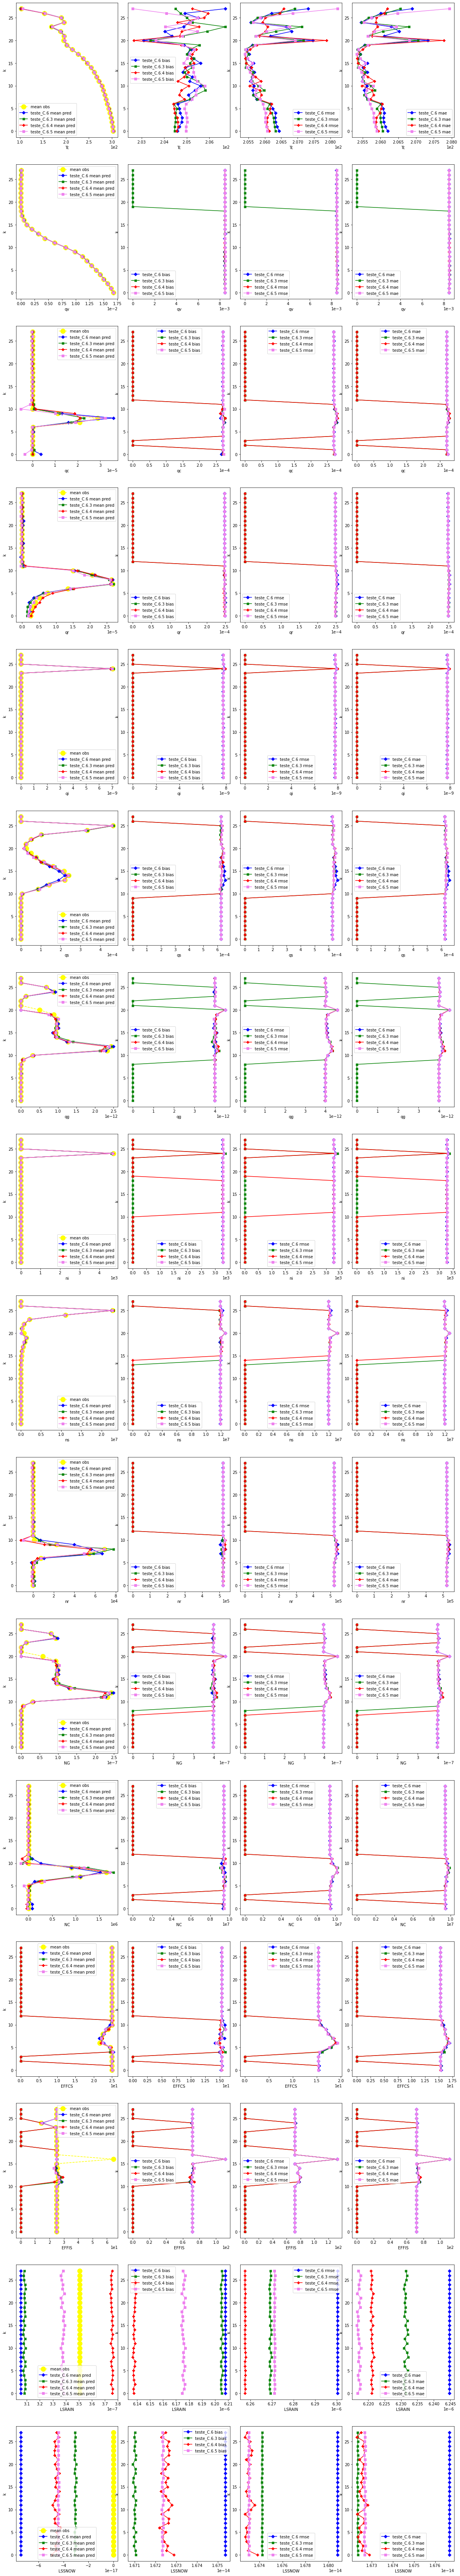

In [44]:
def generate_skill_graphic(skill, skill_fname, key, arr_test, arr_markers, arr_colors, plot_sci_numbers=True):
  for test, mark, color in zip(arr_test, arr_markers, arr_colors):
    path = '{}/{}/{}'.format(exp1_dir, test, skill_fname)  
    df_skill = pd.read_csv(path)
    skill_values = df_skill[key].values
    plt.plot(skill_values, range(len(skill_values)), label=test + ' ' + skill, marker=mark, color=color)
  if plot_sci_numbers:
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
  plt.legend()


def generate_subplot(ncols, nskills, idx_plot, key):
  plt.subplot(ncols, nskills, idx_plot)
  plt.ylabel("k")
  plt.xlabel(key)


def generate_all_graphics(arr_test, cols, obs_file_name, pred_file_name, arr_skills, arr_skill_filenames, arr_markers, arr_colors, plot_sci_numbers=True):
  idx_plot = 1
  plt.figure(figsize=(20, 120))
  for key in cols:
      if key == 'Unnamed: 0': 
        continue
      generate_subplot(len(cols)-1, len(arr_skills)+1, idx_plot, key)

      mean_obs_path = '{}/{}/{}'.format(exp1_dir, arr_test[0], obs_file_name)
      df_mean_obs = pd.read_csv(mean_obs_path)
      obs_values = df_mean_obs[key].values
      plt.plot(obs_values, range(len(obs_values)), label='mean obs',  marker='o', linestyle='dashed', color='yellow', markersize=12)
      
      generate_skill_graphic('mean pred', pred_file_name, key, arr_test, arr_markers, arr_colors, plot_sci_numbers)
      idx_plot += 1

      for skill, skill_fname in zip(arr_skills, arr_skill_filenames):
        generate_subplot(len(cols)-1, len(arr_skills)+1, idx_plot, key)
        generate_skill_graphic(skill, skill_fname, key, arr_test, arr_markers, arr_colors, plot_sci_numbers)
        idx_plot += 1
  
  plt.subplots_adjust(hspace=0.2, wspace=0.1)
  plt.show()



# exp1_dir = '/content/drive/My Drive/Colab Notebooks/logs_models_rttmg_dt60'
exp1_dir = '/content/drive/My Drive/Colab Notebooks/logs'

arr_test = ['teste_C.6', 'teste_C.6.3', 'teste_C.6.4', 'teste_C.6.5' ]
arr_markers = ['D', 'X', 'P', 's']
arr_colors = ['blue', 'green', 'red', 'violet']
dummy_path = '{}/{}/{}'.format(exp1_dir, 'teste_C.6', 'log_mean_obs_denorm.csv')
dummy_df = pd.read_csv(dummy_path)

arr_skills = ['bias', 'rmse', 'mae']

obs_file_name = 'log_mean_obs_denorm.csv'
pred_file_name = 'log_mean_pred_denorm.csv'
arr_skill_filenames = ['log_bias_denorm.csv', 'log_rmse_denorm.csv', 'log_mae_denorm.csv']
generate_all_graphics(arr_test, dummy_df.columns.to_list(), obs_file_name, pred_file_name, arr_skills, arr_skill_filenames, arr_markers, arr_colors)

# obs_file_name = 'log_mean_obs.csv'
# pred_file_name = 'log_mean_pred.csv'
# arr_skill_filenames = ['log_bias.csv', 'log_rmse.csv', 'log_mae.csv']
# generate_all_graphics(arr_test, dummy_df.columns.to_list(), obs_file_name, pred_file_name, arr_skills, arr_skill_filenames, arr_markers, arr_colors, False)

